##  **Exploratory Data Analysis**

Missing values and outliers in the columns selected for the study need to be reviewed. Missing values should be removed or imputed, while outliers should be removed, transformed, or otherwise treated during the analysis.

### Import libraries and parameters
First, we are going to import the libraries needed to perform data ingestion.

In [1]:
# Import libraries
import os
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import numpy as np
import math
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import geopandas as gpd
import contextily as ctx

import folium

import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq
from dateutil import parser
import zipfile
from collections import Counter

from modules.dataset_modules.uploader import write_parquet, write_csv

from modules.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, URL_LIST, POLLUTANTS, MUNICIPALITY

WATER_QUALITY_FILE = "water_quality_data.xlsb"
SUBDIR = "../data/raw/"
ALL_POLLUTANTS = [
 'ALC_FEN',
 'ALC_TOT',
 'CO3',
 'HCO3',
 'OH',
 'CLOROF_A',
 'COLI_FEC',
 'COLI_TOT',
 'E_COLI',
 'COT',
 'COT_SOL',
 'DBO_SOL',
 'DBO_TOT',
 'DQO_SOL',
 'DQO_TOT',
 'N_NH3',
 'N_NO2',
 'N_NO3',
 'N_ORG',
 'N_TOT',
 'N_TOTK',
 'TOX_D_48_UT',
 'TOX_D_48_SUP_UT',
 'TOX_D_48_FON_UT',
 'TOX_FIS_SUP_15_UT',
 'TOX_FIS_SUP_30_UT',
 'TOX_FIS_SUP_5_UT',
 'TOX_FIS_FON_15_UT',
 'TOX_FIS_FON_30_UT',
 'TOX_FIS_FON_5_UT',
 'TOX_V_15_UT',
 'TOX_V_30_UT',
 'TOX_V_5_UT',
 'AOXF',
 'AOXP',
 'AOXT',
 'P_TOT',
 'PO4_TOT',
 'ORTO_PO4',
 'COLOR_VER',
 'TRANSPARENCIA',
 'ABS_UV',
 'SDT',
 'CONDUC_CAMPO',
 'CONDUC_CAMPO_SUP',
 'CONDUC_CAMPO_MED',
 'CONDUC_CAMPO_FON',
 'pH_CAMPO',
 'pH_CAMPO_SUP',
 'pH_CAMPO_MED',
 'pH_CAMPO_FON',
 'SALINIDAD_SUP',
 'SALINIDAD_MED',
 'SALINIDAD_FON',
 'OD_%',
 'OD_mg/L',
 'OD_%_SUP',
 'OD_mg/L_SUP',
 'OD_%_MED',
 'OD_mg/L_MED',
 'OD_%_FON',
 'OD_mg/L_FON',
 '1,1,1,2_TTCETA',
 '1,1,2,2_TETRACLETAN',
 '1,1,2_TCETA',
 '1,1_DICLETILEN',
 '1,2,4_TRICLBENCEN',
 '1,2_DIBR_3_CLPROPAN',
 '1,2_DICLETAN',
 '1,2_DICLPROPAN',
 '1,2_DIFENILHIDRACINA',
 '1_C_NAF',
 '2,3_DICLOROFENOL_DCF',
 '2,4,5_T',
 '2,4,5_TRICLOROFENOL',
 '2,4,6_TRICLFENOL',
 '2,4_D_D_C_FENOXIACETICO',
 '2,4_DICLFENOL',
 '2,4_DIMETILFEN',
 '2,4_DINITOL',
 '2,4_DNF',
 '2,6_DINTOL',
 '2_CEVE',
 '2_CF',
 '2_CLNAFT',
 '2_NIFENOL',
 '4_BRFENFENETER',
 '4_NITROFENOL',
 'ACENAF',
 'ACENAFTIL',
 'ANTRA',
 'BEN_A_ANT',
 'BEN_A_PIR',
 'BEN_B_FANT',
 'BEN_G,H,I_PER',
 'BEN_K_FANT',
 'CRISENO',
 'DIBEN_ANT',
 'FENANTRENO',
 'FLUORANTENO',
 'FLUORENO',
 'IND_PIR',
 'NAFTALENO',
 'PIRENO',
 'HAPS',
 'ACRILONITRILO',
 'ACROLEINA',
 'AL_TOT',
 'ALACLOR',
 'ALDICARB',
 'ALDRIN',
 'ATRAZINA',
 'B_TOT',
 'B2_ETILHEXIL_FTALATO',
 'BA_TOT',
 'BE_TOT',
 'BENCENO',
 'BENCIDINA',
 'BIS2_CLETETER',
 'BIS2_CLIOISOPET',
 'BOLSTAR',
 'BPCS',
 'BR_CLMET',
 'BROMOMETANO',
 'CARBOFURANO',
 'CIS_1,2_DICLETEN',
 'CL_BENC',
 'CL_METILENO',
 'CL_RES',
 'CLORATALONIL',
 'CLORDANO',
 'CLOROMETANO',
 'CLOROTOLURON',
 'CLORPIRYFOS',
 'CLORURO_DE_VINILO',
 'CLORUROS_TOT',
 'COUMAFOS',
 'CR_HEX',
 'CYANACINA',
 'DALAPON',
 'DDD',
 'DDE',
 'DDT',
 'DELTAMETRINA',
 'DEMETON_S',
 'DI_2_ETILEXIL_ADIPATO',
 'DIAZINON',
 'DICAMBA',
 'DICLORVOS',
 'DIELDRIN',
 'DIET_FTAL',
 'DIMETIL_FTAL',
 'DIMETOATO',
 'DINITRO_O_CRESOL',
 'DINOSEB',
 'DIURON',
 'END_ALD',
 'ENDO_SUL',
 'ALFA_ENDO',
 'BETA_ENDO',
 'ENDO_SULSO4',
 'ENDRIN',
 'ENTEROC_FEC',
 'EPN',
 'ESTIRENO',
 'ETILBENCENO',
 'ETOPROP',
 'FE_TOT',
 'FENITROTION',
 'FENOL',
 'FENOLES_TOT',
 'FENSULFOTION',
 'FENTION',
 'FLUORUROS_TOT',
 'FORATO',
 'GLIFOSATO',
 'GRAS_ACEI',
 'H_HELMINTOS',
 'HEPTA_EPOX',
 'HEPTACLOR',
 'HEXACL_BENC',
 'HEXACL_BUT',
 'HEXACL_CICLOPEN',
 'HEXACL_ETANO',
 'ISO_FOR',
 'ISOPROTURON',
 'K_TOT',
 'LINURON',
 'MALATION',
 'MAT_FLOTANTE',
 'MCPA',
 'MERFOS',
 'METIL_AZINF_GUT',
 'METILPARATION',
 'METILTERBUTILETER_MTBE_',
 'METOLACLOR',
 'METOXICLO',
 'MEVINFOS',
 'MIREX',
 'MN_TOT',
 'MO_TOT',
 'MOLINATO',
 'N_NITROS_DIMETILA',
 'N_NITROS_N_PROPAM',
 'N_NITROSODIFENILAMINA',
 'NA_TOT',
 'NITROBENCENO',
 'OXAMIL',
 'PARATION',
 'PCBEN',
 'PENDIMETALIN',
 'PENTACLOROFENOL',
 'PICLORAN',
 'PIRYPROXYFEN',
 'RONNEL',
 'SAAM',
 'SB_TOT',
 'SE_TOT',
 'SILVEX',
 'SIMAZINA',
 'SIO2',
 'SO4_TOT',
 'SOLID_SED',
 'SST',
 'SULFOTEP',
 'SULFUROS_TOT',
 'TALIO',
 'TERBUFOS',
 'TERBUTILAZINA',
 'TETRACL_CARB',
 'TETRACLOROETILENO_',
 'TOKUTION',
 'TOLUENO',
 'TOXAFENO',
 'TRANS_1,2_DICLOROETILENO',
 'TRIALATO',
 'TRICLORANATO',
 'TRICLORFON',
 'TRICLOROETILENO',
 'TRICLOROFLUOROMETANO',
 'TRIFLURALIN',
 'TURBIEDAD',
 'AS_TOT',
 'CD_TOT',
 'CR_TOT',
 'HG_TOT',
 'NI_TOT',
 'PB_TOT',
 'CN_TOT',
 'CU_TOT',
 'ZN_TOT',
 'POT_REDOX_CAMPO',
 'POT_REDOX_CAMPO_FON',
 'POT_REDOX_CAMPO_MED',
 'POT_REDOX_CAMPO_SUP',
 'ACENAF_8310',
 'ACENAFTIL_8310',
 'ANTRA_8310',
 'BEN_A_ANT_8310',
 'BEN_A_PIR_8310',
 'BEN_B_FANT_8310',
 'BEN_G,H,I_PER_8310',
 'BEN_K_FANT_8310',
 'CRISENO_8310',
 'DIBEN_ANT_8310',
 'FENANTRENO_8310',
 'FLUORANTENO_8310',
 'FLUORENO_8310',
 'IND_PIR_8310',
 'NAFTALENO_8310',
 'PIRENO_8310',
 'HAPS_8310',
 '1,2_DICLBENC',
 '1,3_DICLBEN',
 '1,4_DICLBEN',
 'DICLOROBENCENOS',
 'BR_DICLMET',
 'BROMOF',
 'CLOROFORMO',
 'DIBR_CLMET',
 'THMs',
 'M,P_XILENO',
 'O_XILENO',
 'XILEN_ISOMEROS',
 'ALFA_BHC',
 'BETA_BHC',
 'GAMA_BHC_LIN',
 'DELTA_BHC',
 'BHC_ISOMEROS',
 'CA_TOT',
 'MG_TOT',
 'DUR_TOT',
 'TEMP_AMB',
 'TEMP_AGUA',
 'TEMP_AGUA_SUP',
 'TEMP_AGUA_MED',
 'TEMP_AGUA_FON',
 'PROFUNDIDAD',
 'CAUDAL',
 'CLORUROS_SOL',
 'FLUORUROS_SOL',
 'SO4_SOL',
 'AS_SOL',
 'CD_SOL',
 'CR_SOL',
 'FE_SOL',
 'MN_SOL',
 'HG_SOL',
 'PB_SOL',
 'ZN_SOL',
 'AL_SOL',
 'CU_SOL',
 'TALIO_SOL',
 'NI_SOL',
 'CA_SOL',
 'MG_SOL',
 'K_SOL',
 'NA_SOL',
 'SULFUROS_SOL',
 'BA_SOL',
 'SB_SOL',
 'AG_TOT',
 'S',
 'AMPA',
 'V_TOT',
 'SE',
 'SSV',
 'C.MESÓFILOS AEROBIOS',
 'DUR_Ca',
 'DUR_Mg',
 'NH4',
 'ST',
 'DIBR_MET',
 'DIBROMOETILENO',
 'S_TOT',
 '1,1-DICLOROPROPILENO',
 '1,2,3_TRICLBENCEN',
 '1,2-DIBR_ETA',
 '1,3,5-TRIMETILBENCENO',
 '1,3_DICLPROPAN',
 '2_CLOROTOLUENO',
 '2_METILFEN',
 '4_CLOROTOLUENO',
 '4-ISOPROPILTOLUENO',
 'ALC_A',
 'AZOBENCENO',
 'BIS_2_CLOROETOXI_MET',
 'BISMUTO',
 'BROMATOS',
 'BROMOBENCENO',
 'BUTILBENCILFTALATO',
 'CARBAZOLA',
 'CIS-CLORDANO',
 'CLORAMINAS_COMO_CL2_',
 'CLORITOS',
 'CLOROF_B',
 'CLOROF_C',
 'CO_TOT',
 'COLOR_APA',
 'COLOR_VER_436',
 'COLOR_VER_525',
 'COLOR_VER_620',
 'COMP_ORG_NO_HALOG_FID_CONH',
 'CONDUC_LAB',
 'COP',
 'DIBENZOFURANO',
 'DIBUTILFTALATO (DBP)',
 'DICLOROMETANO',
 'DI-OCTILFTALATO',
 'DIQUAT',
 'ENDOSULFAN II',
 'ENDOTAL',
 'ENDRÍN CETONA',
 'HIDROCAR_F_MED',
 'HIDROCAR_F_PES',
 'ISOPROPILBENCENO',
 'Li_TOT',
 'N_NO3-N_NO2',
 'N_ORG_SOL',
 'N-BUTILBENCENO',
 'N-PROPILBENCENO',
 'O-NITROANILINA',
 'P_INORG',
 'P_INORG_DIS',
 'P_ORG',
 'P-CLOROANILINA',
 'pH_LAB',
 'SALINIDAD ',
 'SDF',
 'SDV',
 'SEC-BUTILBENCENO',
 'SN_TOT',
 'SR_TOT',
 'SSF',
 'STF',
 'STV',
 'TALIO_TOT',
 'TER-BUTILBENCENO',
 'Ti_TOT',
 'TRANS-CLORDANO',
 'FORMALDEHIDO',
 'CLORATOS',
 'ACID_CLOROACE',
 'ACID_DICLOROACE',
 'ACID_TRICLOROACE'
 ]

2024-11-18 18:59:35.681 | INFO     | modules.config:<module>:11 - PROJ_ROOT path is: /mnt/Data/Documents/Unison/1 Semestre/Ingeniería de Características/Projects/Sonora-River-Farming/Data-Science-Project


### Load data
We upload the data from the sites and the results of the measurements of the different pollutants. Merge df_water_site and df_water_result DataFrames using 'CLAVE SITIO' as the key. The 'inner' join returns only rows with matching values in both DataFrames. We select the columns required for the study, and in this case we need to select all the pollulants subsequent analysis. We clean the columns of contaminants by removing the > and < symbols and converting them to numeric format, and we remove coastal water bodies. On the other hand, the date column was converted to date format.

In [2]:
df_water_site = pd.read_excel(SUBDIR + WATER_QUALITY_FILE, sheet_name=0)
df_water_result = pd.read_excel(SUBDIR + WATER_QUALITY_FILE, sheet_name=1, parse_dates=['FECHA REALIZACIÓN'])

/tmp/ipykernel_218636/801284402.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_water_result = pd.read_excel(SUBDIR + WATER_QUALITY_FILE, sheet_name=1, parse_dates=['FECHA REALIZACIÓN'])


In [6]:
# Merging df_water_site and df_water_result DataFrames using 'CLAVE SITIO' as the key.
df_water_merged = pd.merge(
    df_water_site, 
    df_water_result, 
    on='CLAVE SITIO', 
    how='inner'
)

# Select the columns required for the study
df_water_merged_filtered = df_water_merged[
    ['CLAVE SITIO', 'ESTADO', 'MUNICIPIO', 'CUERPO DE AGUA', 'TIPO CUERPO DE AGUA', 'SUBTIPO CUERPO AGUA', 'LATITUD', 'LONGITUD', 'FECHA REALIZACIÓN'] + 
    ALL_POLLUTANTS
]

# Convert the 'FECHA REALIZACIÓN' column to the correct datetime format
# First convert the column to numeric
df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_numeric(df_water_merged_filtered['FECHA REALIZACIÓN'], errors='coerce')

# Then convert to dates from Excel origin
df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_datetime(
    df_water_merged_filtered['FECHA REALIZACIÓN'], 
    origin='1899-12-30', 
    unit='D'
)

# Filter the DataFrame to obtain only the records of the water bodies that are not "COASTAL" of the affected municipalities of the state of Sonora.
df_water_filtered_sonora = df_water_merged_filtered[
    (df_water_merged['ESTADO'] == 'SONORA') &
    (df_water_merged['MUNICIPIO'].isin(MUNICIPALITY))   
]
df_water_filtered_sonora = df_water_filtered_sonora[
    ~df_water_filtered_sonora['TIPO CUERPO DE AGUA'].str.contains('COSTERO', na=False)
]

# Clean the columns of pollutants by removing the '>' and '<' symbols and converting them to numeric
for column in ALL_POLLUTANTS:
    if column in df_water_filtered_sonora.columns:
        df_water_filtered_sonora[column] = df_water_filtered_sonora[column].astype(str)
        df_water_filtered_sonora[column] = (
            df_water_filtered_sonora[column]
            .str.replace('<', '', regex=False)
            .str.replace('>', '', regex=False)
        )
        df_water_filtered_sonora[column] = pd.to_numeric(df_water_filtered_sonora[column], errors='coerce')

# Sort by 'CLAVE SITIO' and 'FECHA REALIZACIÓN' in ascending order
df_water_filtered_sonora.sort_values(
    by=['CLAVE SITIO', 'FECHA REALIZACIÓN'], 
    ascending=True, 
    inplace=True, 
    ignore_index=True
)

/tmp/ipykernel_218636/4223021848.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_numeric(df_water_merged_filtered['FECHA REALIZACIÓN'], errors='coerce')
/tmp/ipykernel_218636/4223021848.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_water_merged_filtered['FECHA REALIZACIÓN'] = pd.to_datetime(


### Missing values

**By columns** (*Deletion*)

To analyze the missing values ​​of the columns that interest us, we detect the percentage of missing values in every column of the dataset; if a columns contains a lot of missing values, say more than 30%, and the feature is not significant, we might want to ***delete*** that feature.

**By raws** (Imputations)

The records in the remaining columns that have missing values ​​will be imputed using different methodologies.



#### Deletion

In [7]:
# Calculate the threshold of 70% of the DataFrame length
threshold = len(df_water_filtered_sonora) * 0.7

# Remove columns with more than 70% null data
df_drop_water_sonora = df_water_filtered_sonora.dropna(axis=1, thresh=threshold)

In [8]:
# Select the remaining columns of pollulants after removing the columns with some amount of null data
df_pollulants = df_drop_water_sonora.drop(columns=['CLAVE SITIO', 'ESTADO', 'MUNICIPIO', 'CUERPO DE AGUA',
                                                 'TIPO CUERPO DE AGUA', 'SUBTIPO CUERPO AGUA', 
                                                 'LATITUD', 'LONGITUD', 'FECHA REALIZACIÓN'])
# df_drop_water_sonora.loc[:, selected_cols].columns
df_pollulants

,COLI_FEC,E_COLI,COT,DBO_TOT,DQO_TOT,N_NH3,N_NO2,N_NO3,N_ORG,N_TOT,...,AS_TOT,CD_TOT,CR_TOT,HG_TOT,NI_TOT,PB_TOT,DUR_TOT,TEMP_AMB,TEMP_AGUA,CAUDAL
0,10.0,NaN,1.3280,NaN,NaN,0.053263,0.005,1.706396,0.32898,2.088639,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,507.3396,33.0,22.1,NaN
1,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.738000,NaN,NaN,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,514.0000,30.0,22.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0020,0.001000,0.0020,0.000701,0.00200,0.00200,NaN,NaN,NaN,NaN
3,1658.0,1274.0,NaN,2.0,10.0,NaN,NaN,NaN,NaN,NaN,...,0.0015,0.001301,0.0060,0.000201,0.01700,0.00154,NaN,29.0,29.0,337.0
4,10.0,NaN,0.4537,NaN,NaN,0.078194,0.005,1.054546,1.16265,2.295390,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,345.0658,29.0,19.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,31.0,NaN,NaN,NaN,NaN,NaN,NaN,0.784000,NaN,NaN,...,0.0015,0.001301,0.0060,0.000201,NaN,0.00154,92.4000,27.0,24.0,NaN
469,10.0,NaN,0.8487,NaN,NaN,0.032294,0.005,5.602367,0.01774,5.652401,...,0.0015,0.001301,0.0056,0.000201,0.00042,0.00154,190.0259,32.0,27.7,NaN
470,10.0,NaN,NaN,NaN,NaN,NaN,NaN,5.164000,NaN,NaN,...,0.0080,0.001301,0.0012,0.000201,0.00042,0.00154,404.0000,32.0,27.0,NaN
471,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.602000,NaN,NaN,...,0.0015,0.001301,0.0012,0.000201,0.00042,0.00154,522.0000,27.0,25.0,NaN


#### Imputation

To perform the imputation of missing values, we must first to understand the reasons for the randomness, that is, identify whether these values ​​are:
1. **Missing Completely at Random (MCAR):** The missing values on a given variable (Y) are not associated with other variables in a given data set or with the variable (Y) itself. In other words, there is no particular reason for the missing values.
2. **Missing at Random (MAR):** MAR occurs when the missingness is not random, but where missingness can be fully accounted for by variables where there is complete information.
3. **Missing Not at Random (MNAR):** Missingness depends on unobserved data or the value of the missing data itself.

From the understanding of the randomness of the data we choose the *imputation method*. Note that our data are *time series*, so the imputation methods selected must correspond to *time series problems*:
* Forward Fill
* BackFill
* K-nearest neighbors (KNN) 
* Multivariate Imputation by Chained Equations (MICE)

For some imputation methods like MICE, the presence of some predictive relationship or correlation between data, can help to improve the quality of imputation. We need to verify that the used columns for imputantion have some kind of correlation (Pearson, Spearman, Kendall Tau). Likewise, we need to understand the reasons for the randomness of data. For this purpose we are going to analyze the correlation matrix of non-null values ​​of the studied pollutant and the other columns, to find some kind of correlation, and we are going to analyze the correlation matrix for null values ​​of said columns, to understand the randomness of the missing values. Values ​​closer to 1 (blue) indicate a high positive correlation and values ​​closer to -1 (red) indicate a high negative correlation.

In [9]:
# Function to plot heatmap
def heatmap_plot(df, title, vmin = -1, vmax = 1, cmap = 'coolwarm'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, vmin = vmin, vmax = vmax, annot=True, cmap = cmap)
    plt.title(title)
    plt.show()

In [10]:
# Function to calculate correlation of non-null data
def nonnull_correlation(df, lst, max_missing_ratio = 1, method = 'pearson', plthm = True):

    corr = pd.DataFrame()

    # Calculate the percentage of missing data per column
    missing_ratio = df.isnull().mean()

    # Filter columns with a missing data ratio less than the given threshold
    eligible_columns = missing_ratio[missing_ratio <= max_missing_ratio].index

    if len(eligible_columns) == 0:
        # best_corrs[element] = (None, None)
        raise RuntimeError("No eligible columns, try with other max_missing_ratio")
        
    # Calculate correlation only with eligible columns
    correlations = df[eligible_columns].corr(method = method)
    corr = correlations[lst]

    if plthm:
        heatmap_plot(corr, 'Correlation Heatmap (without NaN values)', -1, 1)
    
    return corr

In [ ]:
# Function to calculate correlation of null data
def nullity_correlation(df, lst, method = 'pearson', plthm = True):

    # Select columns that contain at least one null value
    df_null = df.iloc[:, [i for i, n in enumerate(np.var(df.isnull(), axis='rows')) if n > 0]]

    # Calculate correlation
    corr = df_null.isnull().corr(method = method)[lst]

    if plthm:
        heatmap_plot(corr, 'Correlation Heatmap for NaN values', -1, 1)
    
    return corr

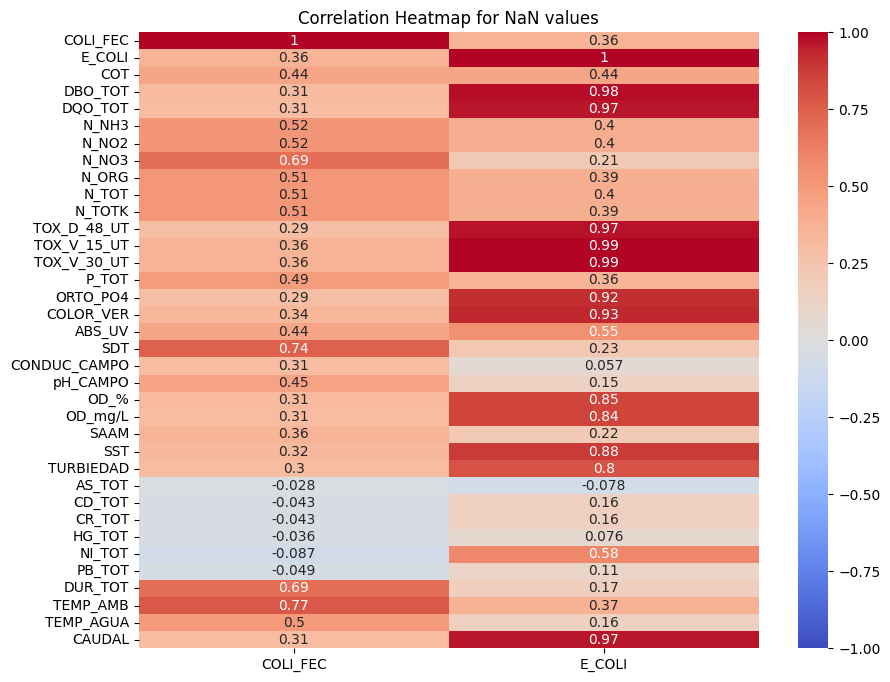

In [10]:
corr_null = nullity_correlation(df=df_pollulants, lst=['COLI_FEC', 'E_COLI'])
# corr_null

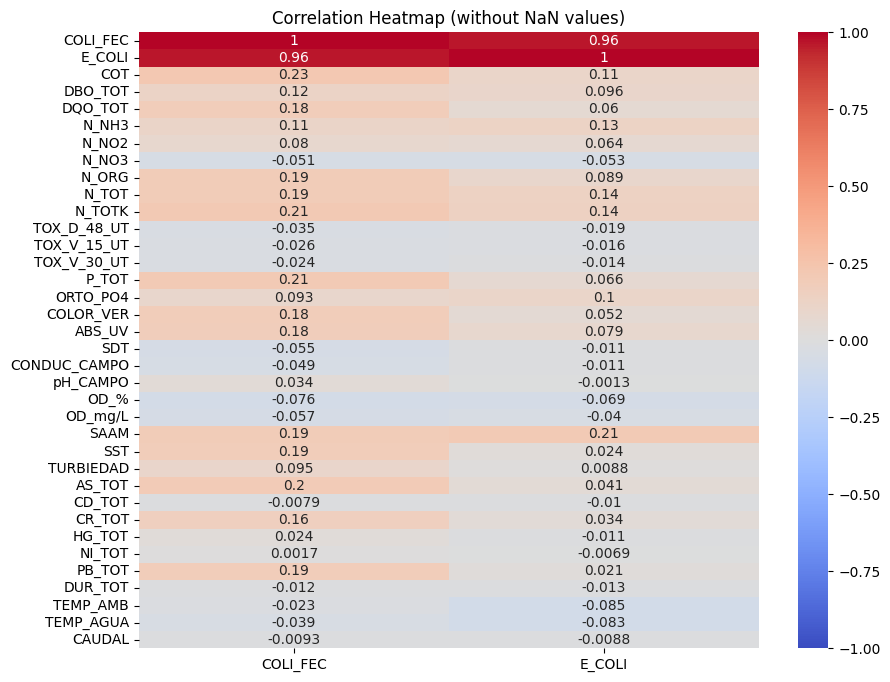

In [11]:
corr = nonnull_correlation(df_pollulants, lst=['COLI_FEC', 'E_COLI'])

In [ ]:
# Function to select the best pairwaise correlation bewteen non-null data correlation and nullity correlation
def best_corr_choice(df, lst, col, top_n=None, plthm_nonnull=True, plthm_null=True):
    corr = nonnull_correlation(df_pollulants, lst=lst, plthm=plthm_nonnull)
    corr_null = nullity_correlation(df=df_pollulants, lst=lst, plthm=plthm_null)

    mask = corr.index != col
    result = abs(corr.loc[mask, col] / corr_null.loc[mask, col])
    choice = result.sort_values(ascending=False).iloc[:top_n] if top_n else result.sort_values(ascending=False)
    
    return choice

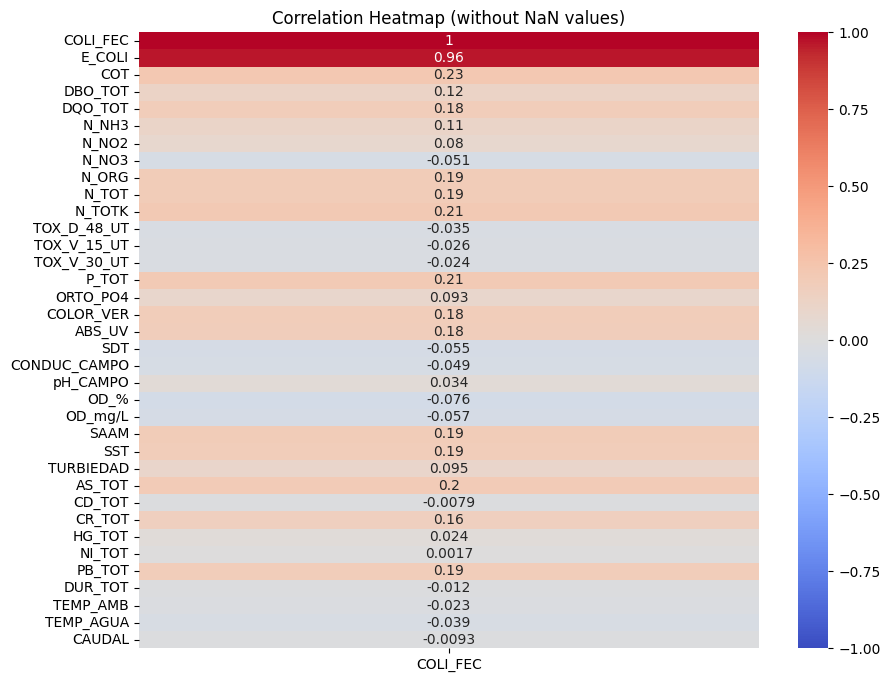

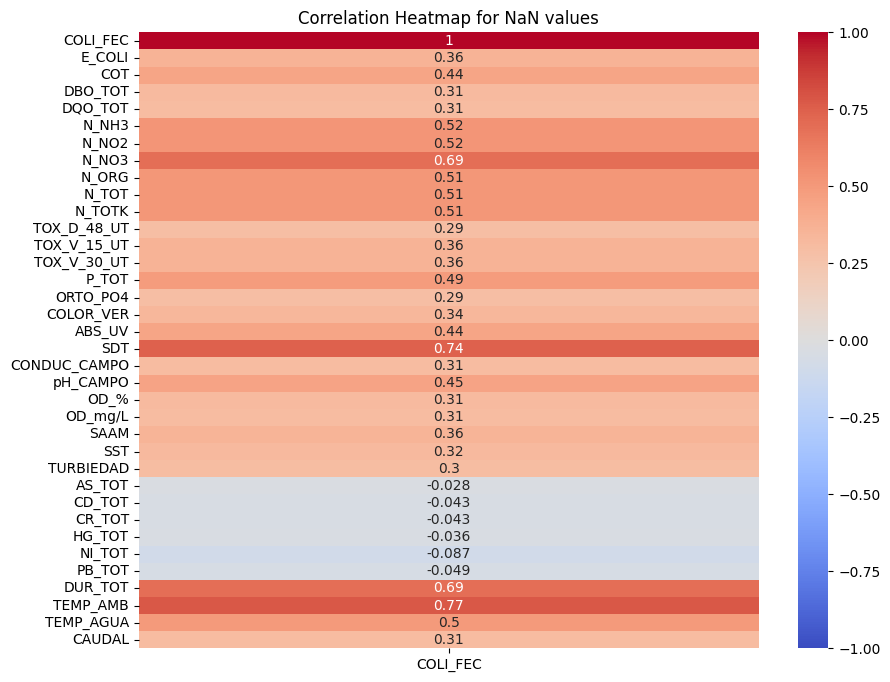

AS_TOT       6.967605
PB_TOT       3.839568
CR_TOT       3.801222
E_COLI       2.657821
HG_TOT       0.652756
DQO_TOT      0.579293
SST          0.573499
SAAM         0.544630
COLOR_VER    0.543821
COT          0.516306
Name: COLI_FEC, dtype: float64

In [13]:
best = best_corr_choice(df_pollulants, lst=['COLI_FEC'], col='COLI_FEC', top_n=10)
best

In [ ]:
# Function to perform the imputation of missing values using ffill, bfill, knn and mice
def imputation_methods(lst, df_pollulants, all_pollutants=False, top_n=None, poll_lst=None, plthm_nonnull=True, plthm_null=True):
    df_imputation_method = pd.DataFrame()
    
    for idx, poll in enumerate(lst):
        df_polls = pd.DataFrame()
        if all_pollutants:
            df_polls = df_pollulants
        elif(top_n):          
            plthm_nonnull_corr = plthm_nonnull if idx==0 else False
            plthm_null_corr = plthm_null if idx==0 else False

            best = best_corr_choice(df_pollulants, lst=lst, col=poll, top_n=top_n, plthm_nonnull=plthm_nonnull_corr, plthm_null=plthm_null_corr)
            s = [poll] + best.index.to_list()
            df_polls = df_pollulants[s]
        elif(poll_lst):

            if len(lst) > 1:
                raise RuntimeError('If you selected your custom best correlated pollulants, you can only choose one pollulant at a time to analyze')
            s = [poll] + poll_lst
            df_polls = df_pollulants[s]
            
        
        # Forward Fill
        df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)

        # BackFill
        df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)

        # KNN Based
        knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
        df_imputation_method[poll+'_knn'] = knn_imputer.fit_transform(df_pollulants[[poll]])

        # MICE
        mice_imputer = IterativeImputer(max_iter=100, random_state=0)
        imputed_values = mice_imputer.fit_transform(df_polls)
        df_imputation_method[poll+'_mice'] = imputed_values[:, df_polls.columns.get_loc(poll)]

        print(f'Forward Fill return {df_imputation_method[poll+'_ffill'].isna().sum()} missing values for {poll}')
        print(f'BackFill return {df_imputation_method[poll+'_bfill'].isna().sum()} missing values for {poll}')
        print(f'KNN return {df_imputation_method[poll+'_knn'].isna().sum()} missing values for {poll}')
        print(f'MICE return {df_imputation_method[poll+'_mice'].isna().sum()} missing values for {poll}')

    return df_imputation_method

In [ ]:
# Pollulant to be analyzed
chosen_poll = 'PB_TOT'

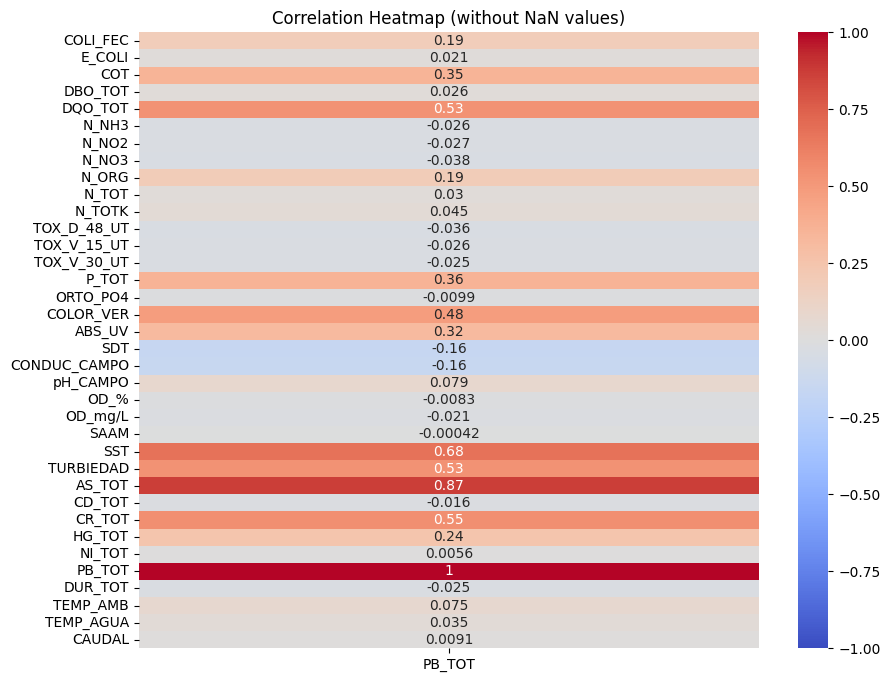

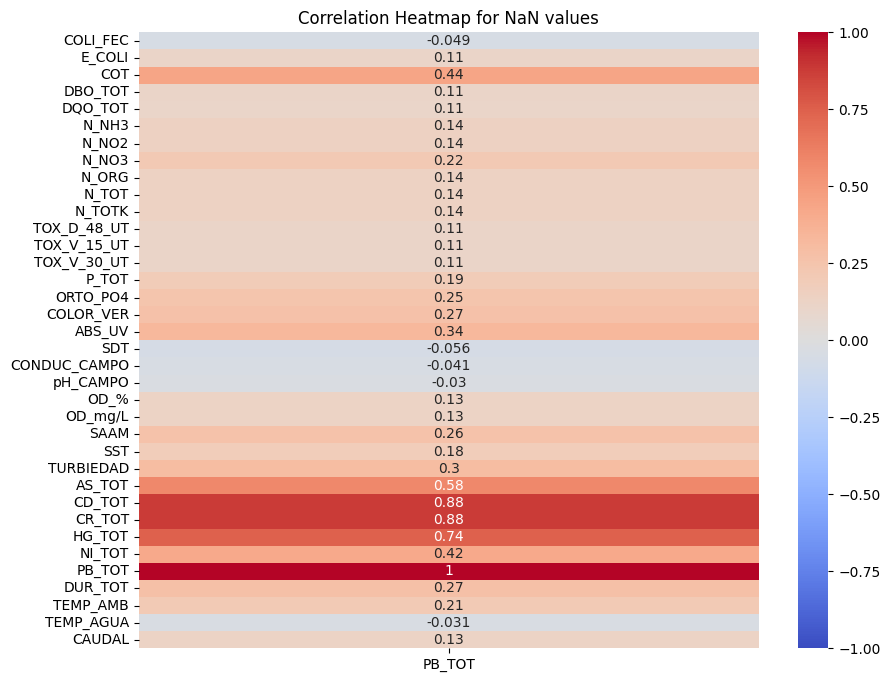

Forward Fill return 0 missing values for PB_TOT
BackFill return 0 missing values for PB_TOT
KNN return 0 missing values for PB_TOT
MICE return 0 missing values for PB_TOT


/tmp/ipykernel_218636/1926482110.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)
/tmp/ipykernel_218636/1926482110.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)


,PB_TOT_ffill,PB_TOT_bfill,PB_TOT_knn,PB_TOT_mice
0,0.00154,0.00154,0.00154,0.00154
1,0.00154,0.00154,0.00154,0.00154
2,0.00200,0.00200,0.00200,0.00200
3,0.00154,0.00154,0.00154,0.00154
4,0.00154,0.00154,0.00154,0.00154
...,...,...,...,...
468,0.00154,0.00154,0.00154,0.00154
469,0.00154,0.00154,0.00154,0.00154
470,0.00154,0.00154,0.00154,0.00154
471,0.00154,0.00154,0.00154,0.00154


In [15]:
df_imp = imputation_methods(lst=[chosen_poll], df_pollulants=df_pollulants, all_pollutants=False, top_n=10, poll_lst=None)
df_imp

##### Charts of Imputation Methods

Distribution density and scatter plots are very useful for comparing imputation methods, in order to find the graph of the method that most closely resembles the original distribution. If the density curve of the imputed data is closely aligned with the original data curve, it is likely that the imputation method is very suitable. Large deviations (for example, shifted or flattened curves) indicate that the imputation method introduces bias or does not preserve the distribution of the original data. On the other hand, the scatter plot shows us if the methods used generate new outliers, or values ​​that are inconsistent with the study, for example, negative values ​​in this case.

In [ ]:
# KDE graphs to compare the imputation methods
def plot_distribution(df, df_imp, poll, figsize=(18, 5)):
    sum_imp = df_imp.isna().sum()
    nonull = sum_imp[sum_imp == 0]
    poll_nonull = nonull.filter(like=poll)
    cols = 2
    rows = math.ceil(len(poll_nonull) / 2)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    axes = axes.flatten()

    for i, c in enumerate(poll_nonull.index):
        method = c.split('_', -1)[-1]
        sns.kdeplot(df[poll], label='Original distribution', fill=True, ax=axes[i])
        sns.kdeplot(df_imp[c], label=f'{method} distribution', fill=True, ax=axes[i])
        axes[i].set_title(f'Original distribution vs {method} distribution ({poll})')
        axes[i].legend()

    # Ajuste de diseño
    plt.tight_layout()
    plt.show()

PB_TOT_ffill
PB_TOT_bfill
PB_TOT_knn
PB_TOT_mice


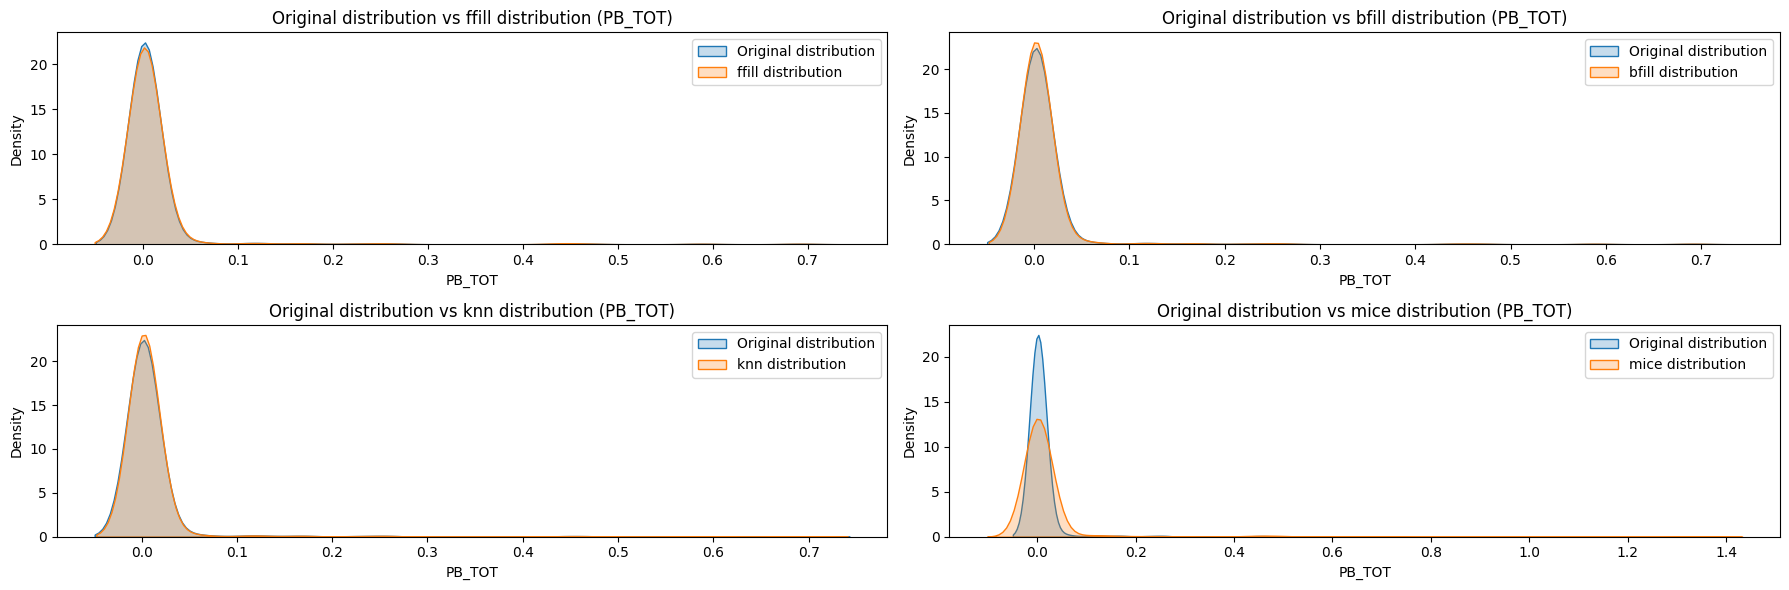

In [17]:
plot_distribution(df_drop_water_sonora, df_imp, chosen_poll, figsize=(18,6))

In [18]:
# Scatter graphs to compare the imputation methods
def plot_scatter(df, df_imp, poll, figsize=(18, 5)):
    sum_imp = df_imp.isna().sum()
    nonull = sum_imp[sum_imp == 0]
    poll_nonull = nonull.filter(like=poll)
    cols = 2
    rows = math.ceil(len(poll_nonull) / 2)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    axes = axes.flatten()

    for i, c in enumerate(poll_nonull.index):
        method = c.split('_', -1)[-1]
        sns.scatterplot(df[poll], label='Original data', alpha=0.6, s=80, color='blue', ax=axes[i])
        sns.scatterplot(df_imp[c], label=f'Imputed data with {method}', alpha=0.6, s=80, color='orange', ax=axes[i])
        axes[i].set_title(f'Original data vs imputed data with {method} ({poll})')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

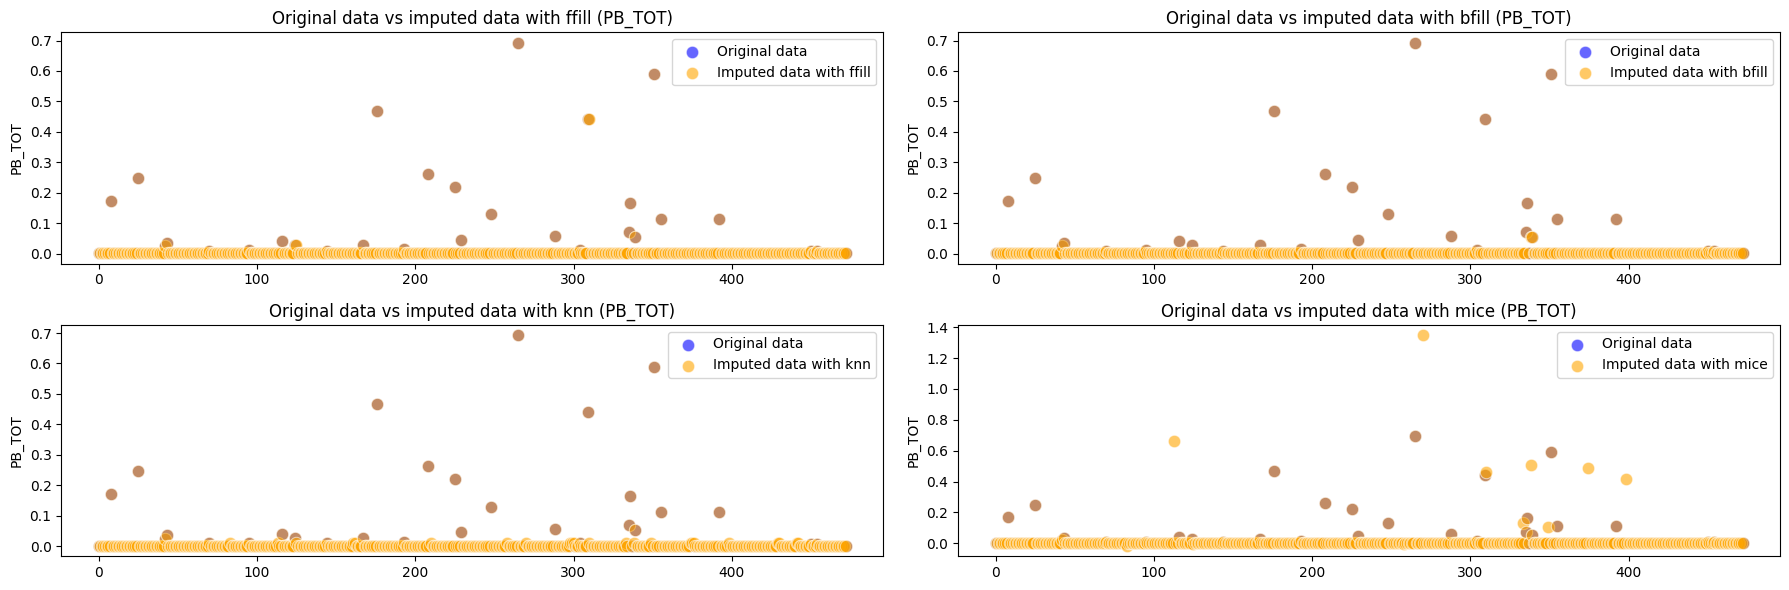

In [19]:
plot_scatter(df_drop_water_sonora, df_imp, chosen_poll, figsize=(18,6))

### Outliers
#### Outliers Detection
Our data set features outliers that deviate significantly from the other values. In other words, they are points that are very far from the majority of the data in a distribution. These values ​​can be unusual, extreme, or unexpected. They can typically be present due to:

* Errors in data collection or entry (for example, a typo or measurement problem).
* Real phenomena that represent extreme or rare conditions.

The following methods will be used to detect outliers:
    
* Minumun Covariance Determinant (MCD)
* Empirical Covariance (MLE)
* Local Outlier Factor (LOF)
* Isolation Forest (IF)

For the MCD and MLE methods the points furthest from the red color are identified as outliers, for the LOF and IF methods the points furthest from the blue color are identified as outliers.

In [ ]:
# Function to graph the results of outlier detection
def plot_outliers(df, column, estimates, title):
    split = column.rsplit('_', 1)
    m = split[-1]
    p = split[0]

    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    # sns.set_style('whitegrid')

    # Minimum Covariance Determinant (MCD) robust
    ax1 = sns.scatterplot(
        x=range(len(df[column])),
        y=df[column], 
        hue=estimates['MCD'],
        palette='RdBu', 
        legend=False, 
        s=80, 
        ax=axes[0, 0]
    )
    # ax1.grid(False)
    norm1 = mpl.colors.Normalize(vmin=estimates['MCD'].min(), vmax=estimates['MCD'].max())
    sm1 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm1)
    sm1.set_array([])
    cax1 = fig.colorbar(sm1, ax=axes[0, 0], orientation="vertical", fraction=0.046, pad=0.04)
    axes[0, 0].set_title(f'Analysis of outliers using Minimum Covariance Determinant (MCD) {title}')
    axes[0, 0].set_ylabel(p)

    # Empirical Covariance (MLE) estimator
    ax2 = sns.scatterplot(
        x=range(len(df[column])),
        y=df[column], 
        hue=estimates['MLE'],
        palette='RdBu', 
        legend=False, 
        s=80, 
        ax=axes[0, 1]
    )
    # ax2.grid(True)
    norm2 = mpl.colors.Normalize(vmin=estimates['MLE'].min(), vmax=estimates['MLE'].max())
    sm2 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm2)
    sm2.set_array([])
    cax2 = fig.colorbar(sm2, ax=axes[0, 1], orientation="vertical", fraction=0.046, pad=0.04)
    axes[0, 1].set_title(f'Analysis of outliers using Empirical Covariance (MLE) {title}')
    axes[0, 1].set_ylabel(p)

    # Local Outlier Factor
    ax3 = sns.scatterplot(
        x=range(len(df[column])),
        y=df[column], 
        hue=estimates['LOF'],
        palette='RdBu', 
        legend=False, 
        s=80, 
        ax=axes[1, 0]
    )
    norm3 = mpl.colors.Normalize(vmin=estimates['LOF'].min(), vmax=estimates['LOF'].max())
    sm3 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm3)
    sm3.set_array([])
    cax3 = fig.colorbar(sm3, ax=axes[1, 0], orientation="vertical", fraction=0.046, pad=0.04)
    axes[1, 0].set_title(f'Analysis of outliers using Local Outlier Factor {title}')
    axes[1, 0].set_ylabel(p)

    # Isolation Forest estimator
    ax4 = sns.scatterplot(
        x=range(len(df[column])),
        y=df[column], 
        hue=estimates['IF'],
        palette='RdBu', 
        legend=False, 
        s=80, 
        ax=axes[1, 1]
    )
    norm4 = mpl.colors.Normalize(vmin=estimates['IF'].min(), vmax=estimates['IF'].max())
    sm4 = mpl.cm.ScalarMappable(cmap="RdBu", norm=norm4)
    sm4.set_array([])
    cax4 = fig.colorbar(sm4, ax=axes[1, 1], orientation="vertical", fraction=0.046, pad=0.04)
    axes[1, 1].set_title(f'Analysis of outliers using Isolation Forest {title}')
    axes[1, 1].set_ylabel(p)

    plt.tight_layout()
    
    plt.figure(figsize=(25, 7)) 
    plt.scatter(df_drop_water_sonora['FECHA REALIZACIÓN'], df_imp[column])
    plt.xlabel('Date')
    plt.ylabel(p)
    plt.title(f'{p} concentration over time')
    
    plt.show()

In [21]:
# Treatment of outliers using various method of outlier detection
def outlier_detection(df, method, poll, plot=True):
    column = '_'.join([method, poll])
    df_column = df[[column]]

    # Minimum Covariance Determinant (MCD) robust estimator
    robust_cov = MinCovDet(support_fraction=0.99).fit(df_column)
    estimate_MCD = robust_cov.mahalanobis(df_column)

    # Empirical Covariance (MLE) estimator
    emp_cov = EmpiricalCovariance().fit(df_column)
    estimate_MLE = emp_cov.mahalanobis(df_column)

    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=100)
    estimate_LOF = lof.fit_predict(df_column)

    # Isolation Forest estimator
    iso_forest = IsolationForest(
        contamination=0.013, 
        n_estimators=100, 
        warm_start=True
    ).fit(df_column)
    estimate_IF = iso_forest.predict(df_column)

    estimates = {
        "MCD": estimate_MCD,
        "MLE": estimate_MLE,
        "LOF": estimate_LOF,
        "IF": estimate_IF
    }

    if plot:
        split = column.rsplit('_', 1)
        m = split[-1]
        p = split[0]
        plot_outliers(df, column, estimates, title=f'in imputed data of {p} with {m}')

    return estimates

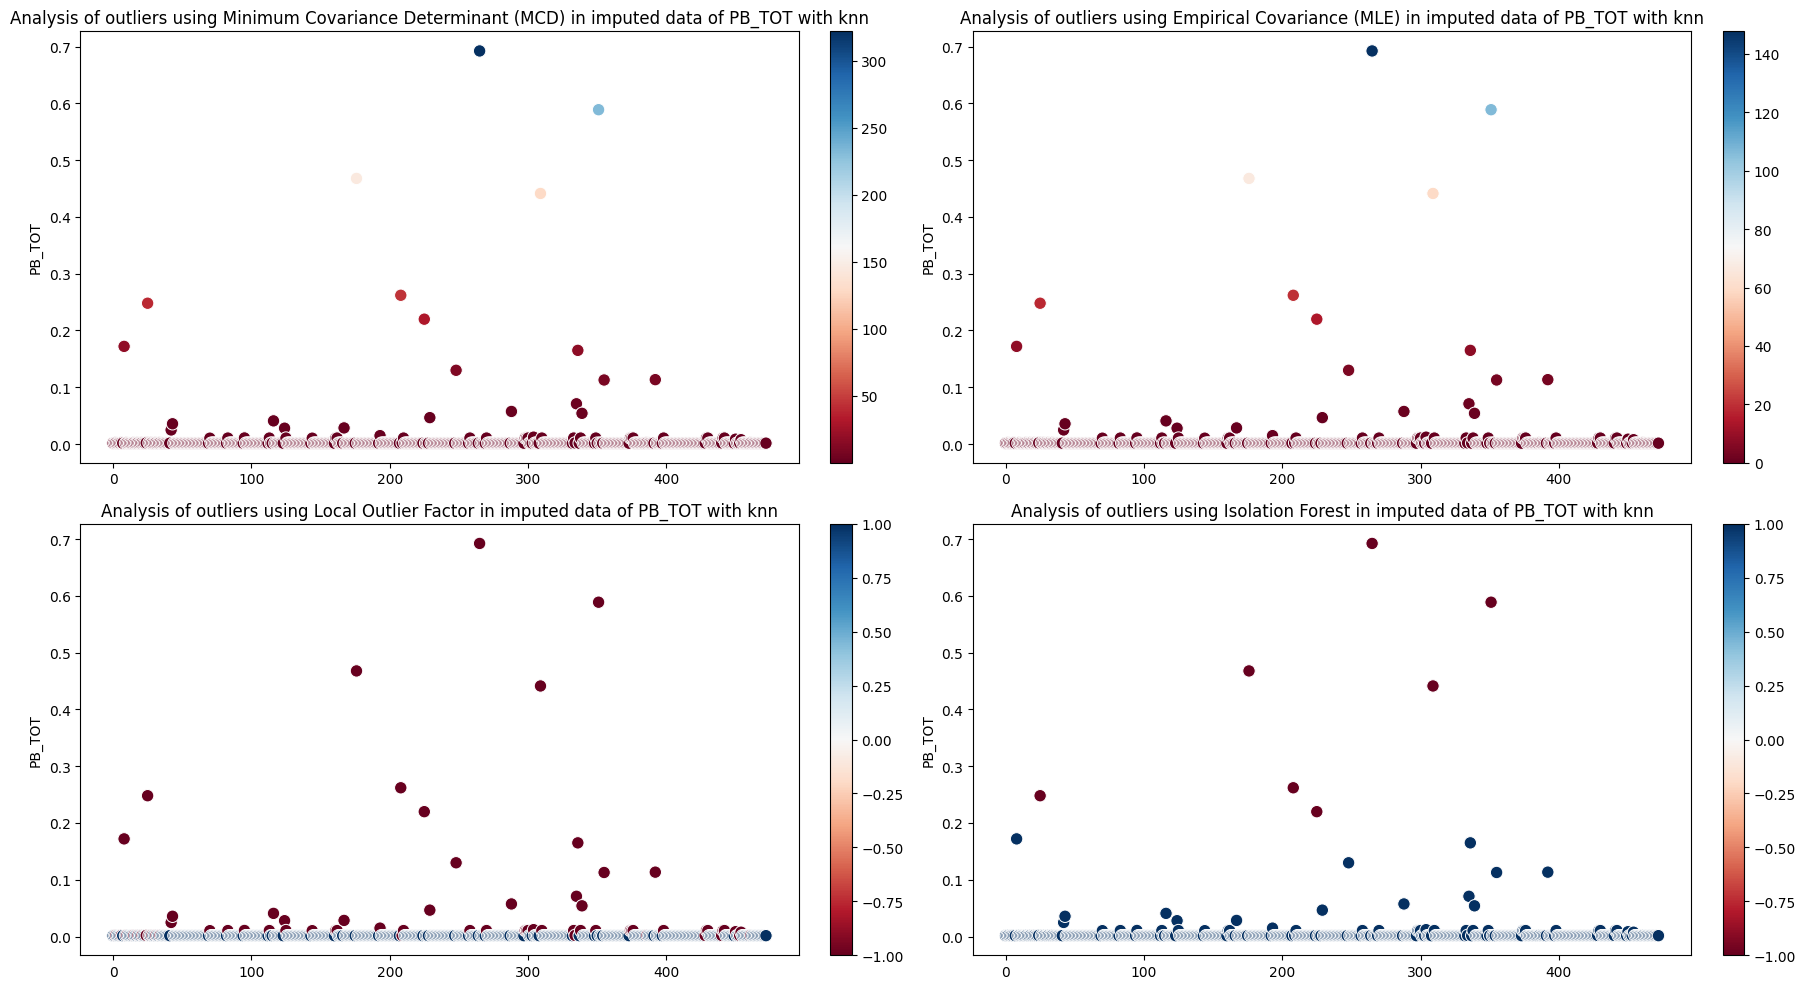

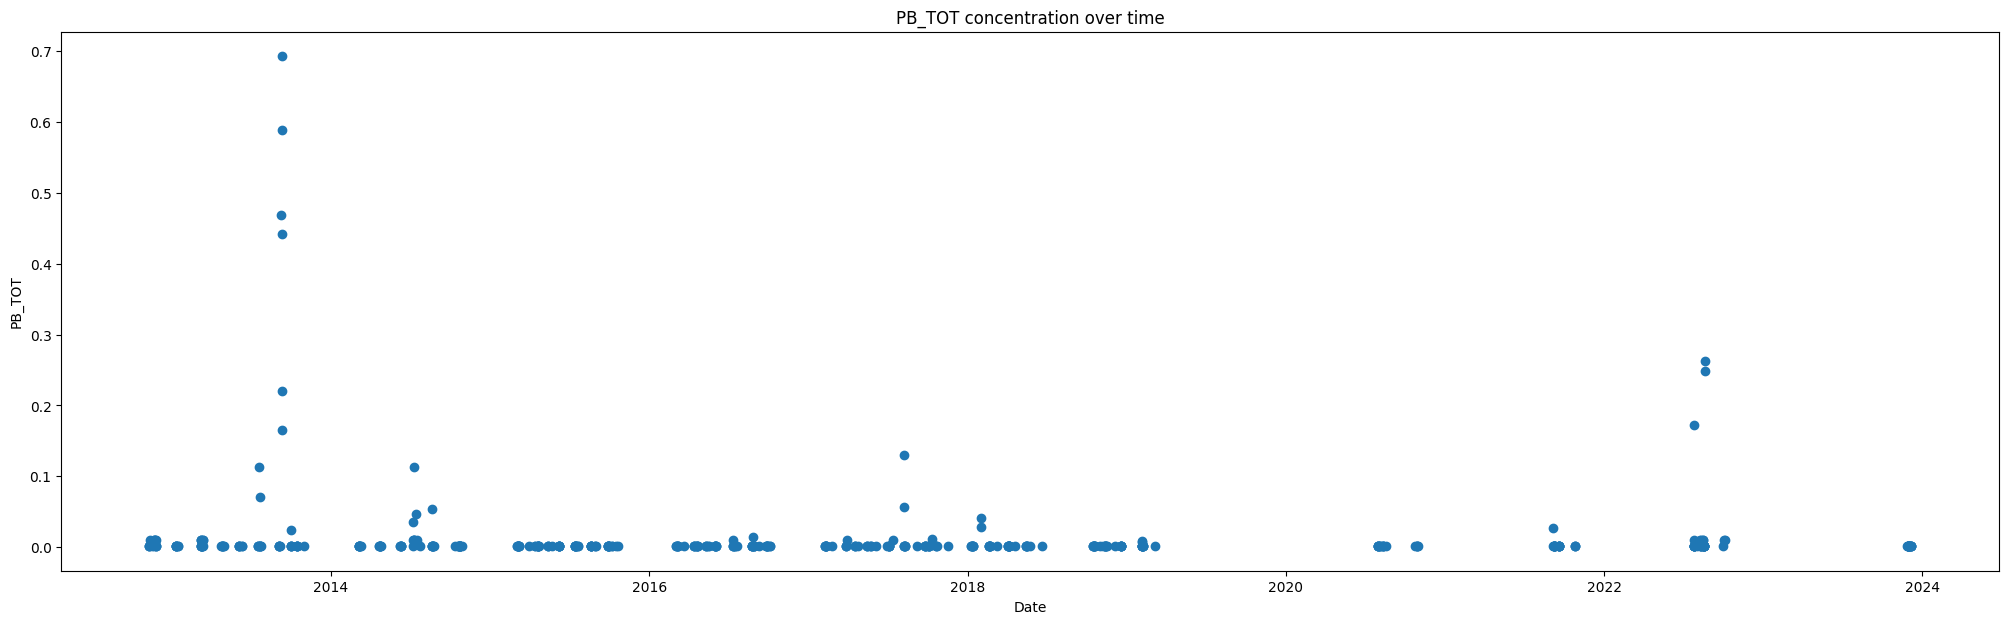

In [22]:
estimates = outlier_detection(df_imp, chosen_poll, 'knn')

#### Outliers Analysis
Once the outliers are identified, the origin of these values ​​is analyzed, taking into account the proximity of the sampling sites that record these outliers to mining activity, the study of the by-products derived from said activity and the influence of the tributaries within the Sonora and Bacanuchi river basins.

In [24]:
def outlier_analysis(df, df_imp, estimates, method, threshold, poll, met_imp, plot=True):
    column = '_'.join([poll, met_imp])
    conditions = {
        'MCD': df_imp[estimates[method] >= threshold],
        'MLE': df_imp[estimates[method] >= threshold],
        'LOF': df_imp[(estimates[method] == threshold)],
        'IF': df_imp[(estimates[method] == threshold)]
    }
    
    # Obtener los outliers basados en el método
    if method not in conditions:
        raise ValueError("Method don't recognized. Use 'MCD', 'MLE', 'LOF' o 'IF'")
    
    outliers = conditions[method][column]
    data = {
        'latitude': [30.973333],
        'longitude': [-110.320278],
        'value': [200]
    }
    df_water = df[df_imp[column].isin(outliers)]
    
    if plot:
        df = pd.concat([df_water[['LATITUD', 'LONGITUD']], df_imp[df_imp[column].isin(outliers)][column]], axis=1)
        df2 = pd.DataFrame(data)

        # Convertir el DataFrame a un GeoDataFrame con puntos geoespaciales
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['LONGITUD'], df['LATITUD']), crs="EPSG:4326")
        gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2['longitude'], df2['latitude']), crs="EPSG:4326")

        # Convertir el sistema de coordenadas a Web Mercator para añadir un mapa de fondo
        gdf = gdf.to_crs(epsg=3857)
        gdf2 = gdf2.to_crs(epsg=3857)

        scale = gdf[column].max() / 1000

        # Crear la figura y el gráfico
        fig, ax = plt.subplots(figsize=(15, 10))
        gdf.plot(ax=ax, markersize=gdf[column]/scale, color='blue', alpha=0.6, edgecolor='k', legend=True)
        gdf2.plot(ax=ax, markersize=gdf2['value'], color='red', alpha=0.6, edgecolor='k', legend=True)


        # Definir límites personalizados para el área a visualizar (ajusta según el área deseada)
        ax.set_xlim([gdf.geometry.x.min() - 100000, gdf.geometry.x.max() + 100000])
        ax.set_ylim([gdf.geometry.y.min() - 100000, gdf.geometry.y.max() + 100000])

        # Añadir el mapa de fondo con un proveedor alternativo
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

        # Ajustes adicionales
        plt.title(f"Geospatial graph of {poll} outliers")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.legend()
        plt.show()

    return df_water[['FECHA REALIZACIÓN', 'MUNICIPIO', 'CUERPO DE AGUA', 'TIPO CUERPO DE AGUA', 'LATITUD', 'LONGITUD', poll]]


    """ gdf.explore(
        marker_kwds={"radius": 25}
    ) """

/tmp/ipykernel_203708/417416579.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


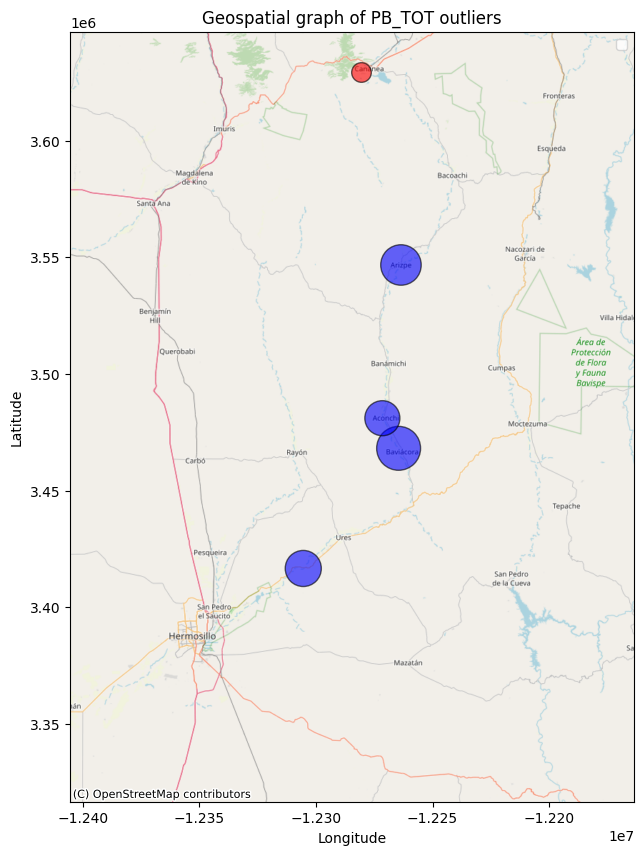

,FECHA REALIZACIÓN,MUNICIPIO,CUERPO DE AGUA,TIPO CUERPO DE AGUA,LATITUD,LONGITUD,PB_TOT
176,2013-09-09,URES,RIO SONORA,LÓTICO,29.32107,-110.54156,0.4678
265,2013-09-10,BAVIÁCORA,RIO SONORA,LÓTICO,29.72369,-110.17441,0.6923
309,2013-09-10,ACONCHI,RIO SONORA,LÓTICO (HUMEDAL),29.82440,-110.23701,0.4413
351,2013-09-10,ARIZPE,RIO SONORA,LÓTICO,30.33503,-110.16534,0.5888


In [25]:
df_water = outlier_analysis(df_drop_water_sonora, df_imp, estimates, 'MLE', 50, chosen_poll, 'knn')
df_water

In [ ]:
# List of outliers by pollutants
list_to_analysis = [
    {
        "poll": "SST",
        "imputation": {
            "method": "knn",
            "top_n": 1
        },
        "outlier": {
            "method": "IF",
            "threshold": -1,
            "support_fraction": None
        }
    },
    {
        "poll": "AS_TOT",
        "imputation": {
            "method": "knn",
            "top_n": 10
        },
        "outlier": {
            "method": "MLE",
            "threshold": 80,
            "support_fraction": 0.75
        }
    },
    {
        "poll": "CD_TOT",
        "imputation": {
            "method": "knn",
            "top_n": 10
        },
        "outlier": {
            "method": "MLE",
            "threshold": 150,
            "support_fraction": 0.9
        }
    },
    {
        "poll": "CR_TOT",
        "imputation": {
            "method": "mice",
            "top_n": 10
        },
        "outlier": {
            "method": "MLE",
            "threshold": 150,
            "support_fraction": 0.75
        }
    },
    {
        "poll": "HG_TOT",
        "imputation": {
            "method": "mice",
            "top_n": 15
        },
        "outlier": {
            "method": "MLE",
            "threshold": 200,
            "support_fraction": 0.99
        }
    },
    {
        "poll": "PB_TOT",
        "imputation": {
            "method": "knn",
            "top_n": 2
        },
        "outlier": {
            "method": "MLE",
            "threshold": 50,
            "support_fraction": 0.99
        }
    }
]

In [ ]:
# Outliers Dataframe
df_to_analysis = pd.DataFrame()
for idx in list_to_analysis:
    df_imp = imputation_methods(lst=[idx['poll']], df_pollulants=df_pollulants, all_pollutants=False, top_n=idx['imputation']['top_n'], poll_lst=None, plthm_nonnull=False, plthm_null=False)
    estimates = outlier_detection(df_imp, idx['poll'], idx['imputation']['method'], plot=False)
    df_water = outlier_analysis(df_drop_water_sonora, df_imp, estimates, idx['outlier']['method'], idx['outlier']['threshold'], idx['poll'], idx['imputation']['method'], plot=False)

    df_to_analysis = pd.concat([df_to_analysis, df_water], axis=0)


df_outliers = df_to_analysis.melt(
    id_vars=['FECHA REALIZACIÓN', 'MUNICIPIO', 'CUERPO DE AGUA', 'TIPO CUERPO DE AGUA', 'LATITUD', 'LONGITUD'],
    value_vars=['SST', 'AS_TOT', 'CD_TOT', 'CR_TOT', 'HG_TOT', 'PB_TOT'],
    var_name='CONTAMINANTE', 
    value_name='VALOR'
)
df_outliers = df_outliers.dropna(subset='VALOR')
df_outliers.sort_values(by='FECHA REALIZACIÓN')

/tmp/ipykernel_203708/1926482110.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)
/tmp/ipykernel_203708/1926482110.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)


Forward Fill return 0 missing values for SST
BackFill return 5 missing values for SST
KNN return 0 missing values for SST
MICE return 0 missing values for SST


/tmp/ipykernel_203708/1926482110.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)
/tmp/ipykernel_203708/1926482110.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)


Forward Fill return 0 missing values for AS_TOT
BackFill return 0 missing values for AS_TOT
KNN return 0 missing values for AS_TOT
MICE return 0 missing values for AS_TOT


/tmp/ipykernel_203708/1926482110.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)
/tmp/ipykernel_203708/1926482110.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)
/mnt/Data/Documents/Unison/1 Semestre/Ingeniería de Características/Projects/Sonora-River-Farming/Data-Science-Project/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Forward Fill return 0 missing values for CD_TOT
BackFill return 0 missing values for CD_TOT
KNN return 0 missing values for CD_TOT
MICE return 0 missing values for CD_TOT


/tmp/ipykernel_203708/1926482110.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)
/tmp/ipykernel_203708/1926482110.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)


Forward Fill return 0 missing values for CR_TOT
BackFill return 0 missing values for CR_TOT
KNN return 0 missing values for CR_TOT
MICE return 0 missing values for CR_TOT


/tmp/ipykernel_203708/1926482110.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)
/tmp/ipykernel_203708/1926482110.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)


Forward Fill return 0 missing values for HG_TOT
BackFill return 0 missing values for HG_TOT
KNN return 0 missing values for HG_TOT
MICE return 0 missing values for HG_TOT


/tmp/ipykernel_203708/1926482110.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_ffill'] = df_pollulants[poll].fillna(method='ffill', inplace=False)
/tmp/ipykernel_203708/1926482110.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputation_method[poll+'_bfill'] = df_pollulants[poll].fillna(method='bfill', inplace=False)


Forward Fill return 0 missing values for PB_TOT
BackFill return 0 missing values for PB_TOT
KNN return 0 missing values for PB_TOT
MICE return 0 missing values for PB_TOT


,FECHA REALIZACIÓN,MUNICIPIO,CUERPO DE AGUA,TIPO CUERPO DE AGUA,LATITUD,LONGITUD,CONTAMINANTE,VALOR
43,2012-11-10,ACONCHI,RIO SONORA,LÓTICO,29.84478,-110.27754,CD_TOT,1.4230
44,2013-03-10,ACONCHI,RIO SONORA,LÓTICO,29.84478,-110.27754,CD_TOT,1.1780
98,2013-09-09,URES,RIO SONORA,LÓTICO,29.32107,-110.54156,PB_TOT,0.4678
101,2013-09-10,ARIZPE,RIO SONORA,LÓTICO,30.33503,-110.16534,PB_TOT,0.5888
99,2013-09-10,BAVIÁCORA,RIO SONORA,LÓTICO,29.72369,-110.17441,PB_TOT,0.6923
4,2013-09-10,ARIZPE,RIO SONORA,LÓTICO,30.33503,-110.16534,SST,5200.0000
100,2013-09-10,ACONCHI,RIO SONORA,LÓTICO (HUMEDAL),29.82440,-110.23701,PB_TOT,0.4413
80,2013-09-30,CANANEA,RIO SONORA,LÓTICO,30.95804,-110.18906,HG_TOT,0.0116
6,2014-07-09,ARIZPE,RIO BACANUCHI,LÓTICO,30.36813,-110.15751,SST,7575.0000
25,2014-07-10,BAVIÁCORA,RIO SONORA,LÓTICO,29.72369,-110.17441,AS_TOT,0.3004


##### Mining origin of these outliers

In mines that extract Copper, Molybdenum, Gold, Silver and Zinc, it is common to find a variety of other minerals and trace elements due to the geochemical association of these metals in nature. Here are some of the additional minerals and elements that are usually present in mines of these metals:
1. Copper Mines
    * Sulfur: Forms sulfides such as chalcopyrite and bornite.
    * Iron: Associated with minerals such as pyrite (FeS₂) and magnetite.
    * Gold and Silver: Frequently present as by-products in some copper deposits.
    * Arsenic: Found in sulfides such as arsenopyrite.
    * Lead and Zinc: Occasionally present in the upper layers of certain copper deposits.

2. Molybdenum mines
    * Copper: Many molybdenum mines also contain copper, especially in the form of chalcopyrite.
    * Sulfur: In sulfides such as molybdenite (MoS₂).
    * Wolfram (Tungsten): Can be found in molybdenum deposits, especially in associated granites.
    * Rhenium: Rare element present in molybdenite in small quantities, valuable as a by-product.

3. Gold Mines
    * Silver: Often associated with gold in epigenetic deposits.
    * Quartz: Common gangue mineral in gold veins.
    * Antimony: Present in minerals such as stibnite (Sb₂S₃).
    * Arsenic: Associated in minerals such as arsenopyrite (FeAsS).
    * Tellurium: Often in the form of gold tellurides such as calaverite (AuTe₂).

4. Silver Mines
    * Gold: Often found together with silver in vein deposits.
    * Copper, Lead and Zinc: Copper, lead and zinc minerals are commonly associated, forming minerals such as galena (PbS) and sphalerite (ZnS).
    * Sulfur: Forms sulfides with silver, such as argentite (Ag₂S).
    * Antimonyio y Arsénico: Común en sulfuros complejos como la tetraedrita ((Cu,Fe)₁₂Sb₄S₁₃).

5. Zinc Mines
    * Lead: Usually present in the form of galena (PbS).
    * Copper: Sometimes present as chalcopyrite (CuFeS₂).
    * Iron: Present in the form of pyrite and marcasite (both FeS₂).
    * Cadmium: Often found as an impurity in zinc minerals such as sphalerite.
    * Manganese: May be found in hydrothermal deposits along with zinc.

These minerals and elements are often present due to the formation conditions of the deposits and the chemistry of hydrothermal fluids. In addition, many of them are extracted as by-products, depending on the profitability of their recovery.

In [28]:
mining_2013 = {
    "NOMBRE": [
        "La Caridad", "Cananea", "La Colorada", "Piedras Verdes", "María", "La Herradura",
        "Mulatos", "El Boludo", "Cerro Colorado", "Álamo Dorado", "Milpillas", "El Chanate", 
        "Santa Elena", "Lluvia de Oro", "Nochebuena", "Dipolo (Soledad)", "Las Mercedes", 
        "San Francisco", "San Felix", "El Volcán", "Cerro Prieto", "La Cienega", "Santa Gertrudis", 
        "El Pilar", "Picacho", "El Tigre Tailings", "Luz del Cobre/ San Antonio", "La India"
    ],
    "COORDENADAS_X": [
        638584, 564877, 542661, 697674, 559560, 322892, 720711, 426209, 420814, 731943, 
        554648, 412738, 580923, 496850, 342843, 317762, 548486, 488688, 341951, 666593, 
        533164, 424090, 543545, 531135, 587789, 670812, 632830, 707399
    ],
    "COORDENADAS_Y": [
        3354404, 3424645, 3185713, 3006208, 3432165, 3447355, 3170866, 3356230, 3343924, 
        2960388, 3442287, 3408647, 3321262, 3398347, 3433944, 3456270, 3355233, 3356408, 
        3386879, 3069254, 3365250, 3343378, 3388890, 3452470, 3384507, 3385665, 3167308, 
        3177281
    ],
    "EMPRESA": [
        "Mexicana de Cobre, S.A. de C.V.", "Buenavista del Cobre S.A. de C.V.", 
        "Pediment Gold Corp / Argonaut Gold Inc.", "Cobre del Mayo S.A. de C.V.", 
        "Minera María, S.A. de C.V.", "Newmont Mining Corp / Fresnillo PLC", 
        "Minas de Oro Nacional S.A. de C.V.", "Minera Secotec, S.A. de C.V.", 
        "Goldgroup Mining Inc.", "Pan American Silver Corp.", "Minera la Parreña, S.A. de C.V.", 
        "Aurico Gold Inc.", "Silver Crest Mines Inc / Sandstorm Resources LTD", 
        "NWM Mining Corporation", "Newmont Mining Corp / Fresnillo PLC", 
        "Newmont Mining Corp / Fresnillo PLC", "Yamana Gold Inc.", "TIMMINS (Gold Corp)", 
        "Mexus Enterprise, S.A. de C.V.", "AERCELOR Mittal Steel Company N.V.", 
        "Oroco Resources Corp", "Alto Group Holding Inc", "Animas Resources LTD", 
        "Mercator Minerals LTD", "Tara Gold Resources LTD", "Tara Minerals Corp", 
        "Zaruma Resources Inc.", "Agnico-Eagle Mines LTD"
    ],
    "MUNICIPIO": [
        "Nacozari", "Cananea", "La Colorada", "Álamos", "Cananea", "Caborca", 
        "Sahuaripa", "Trincheras", "Trincheras", "Álamos", "Santa Cruz", "Altar", 
        "Banamichi", "Magdalena de Kino", "Caborca", "Caborca", "Cucurpe", "Estación Llano", 
        "Caborca", "Rosario", "Cucurpe", "Arivechi", "Cucurpe", "Santa Cruz", 
        "Bacoachi", "Nacozari de García", "Soyopa", "Sahuaripa"
    ],
    "PRODUCCION_TON_DIA": [
        "90,000", "70,000", "4,000", None, None, "4,000", None, "7,000", None, 
        None, "55,000", None, None, None, None, None, None, None, None, None, 
        None, None, None, None, None, None, None, "16,000"
    ],
    "SUSTANCIA": [
        "Cu, Mo, Au, Ag", "Cu, Au, Ag", "Au", "Cu", 
        "Cu, Molibdeno", "Au", "Au", "Au", "Au", "Ag", "Cu", "Au", 
        "Au, Ag", "Au", "Au, Cu", "Au", "Au, Ag", "Au", 
        "Au, Ag", "Fe", "Au, Ag, Pb, Zn", "Au", "Cu", "Au, Cu", "Au", "Au, Ag", 
        "Au, Cu", "Au, Ag"
    ],
    "LATITUD": [
        30.2245, 30.9747, 28.7757, 27.1011, 31.0403, 31.1721, 28.6835, 30.3276, 
        30.1965, 26.7152, 31.1009, 30.7459, 29.9418, 30.6518, 31.0236, 31.2475, 
        30.6229, 30.6327, 30.5561, 27.6966, 30.4106, 30.2073, 30.6031, 31.1805, 
        30.5909, 30.5936, 28.5892, 28.6366
    ],
    "LONGITUD": [
        -109.6764, -110.3036, -110.5287, -108.9437, -110.2116, -112.1091, -109.6983, 
        -111.5589, -111.6438, -108.9921, -110.5555, -111.5625, -110.2068, -110.7752, 
        -111.3722, -112.1632, -111.0725, -111.2002, -112.0015, -112.0031, -111.4847, 
        -110.3194, -110.6358, -111.1914, -110.4427, -109.8862, -109.6412, -109.2025
    ]
}

mining_2017 = {
    "NOMBRE": [
        "La Caridad", "Cananea", "La Colorada", "Piedras Verdes", "María", 
        "La Herradura/Noche Buena", "Mulatos", "El Boludo", "Álamo Dorado", 
        "Milpillas", "El Chanate", "Santa Elena", "Lluvia de Oro/La Jojoba", 
        "Las Mercedes/Delivuar y La Lupita", "San Francisco", "El Volcán", 
        "Cerro Prieto", "La Fierrosa", "Nash", "Luz del Cobre/San Antonio", 
        "La India", "La Cuesta"
    ],
    "EMPRESA": [
        "Mexicana de Cobre, S.A. de C.V.", "Buenavista del Cobre S.A. de C.V.", 
        "Minera Pitalla S.A. de C.V./ Argonaut Gold Inc.", "Inventure Group, SA de CV/Frontier Copper Corp", 
        "Minera María, S.A. de C.V.", "Fresnillo PLC.", "Minas de Oro Nacional S.A. de C.V.", 
        "Minera Secotec, S.A. de C.V.", "Minera Corner Bay S.A. de C.V.", 
        "Compañía Minera la Parreña, S.A. de C.V.", "Álamos Gold", "Santa Elena S.A. de C.V.", 
        "Minera Columbia de México S.A. de C.V./ Nwm Mining Corporation", 
        "Premier Gold Mines", "Timmins Gold Corp México S.A. de C.V", 
        "ARCELOR Mittal Steel Company N.V.", "Goldgroup Mining Inc.", "New Best", 
        "G.E. Galaz S.A. de C.V.", "Minerales Libertad S.A. de C.V.", 
        "Agnico Sonora S.A. de C.V.", "Gaeso"
    ],
    "MUNICIPIO": [
        "Nacozari", "Cananea", "La Colorada", "Álamos", "Cananea", 
        "Caborca", "Sahuaripa", "Trincheras", "Álamos", "Santa Cruz", 
        "Altar", "Banamichi", "Magdalena de Kino", "Cucurpe", 
        "Estación Llano", "Rosario", "Cucurpe", "Bacanora", "Hermosillo", 
        "Soyopa", "Sahuaripa", "Bacanora"
    ],
    "PRODUCCION_TON_DIA": [
        "90,000", "188,000", "4,000", "15,000 ton/anual", None, 
        "4,000", "17,233", "7,000", "4,830", "6,700", "24,237", None, "6,263", 
        "2,000", "3,730 kg/anual", "6,625", None, None, None, "6,000 ton/anual", 
        "16,438", None
    ],
    "SUSTANCIA": [
        "Cu, Mo, Au, Ag", "Cu, Au, Ag, Zn", "Au", "Cu", "Cu, Mo, Au, Ag", 
        "Au", "Au", "Au", "Ag", "Cu", "Au", "Au, Ag", "Au, Ag", 
        "Au, Ag", "Au", "Fe", "Au, Ag, Pb, Zn", "Fe", "Fe", 
        "Cu, Au", "Au, Ag", "Fe"
    ],
    "COORDENADAS_X": [
        638495, 565000, 541348, 697265, 555596, 322338, 720711, 426298, 
        731943, 554648, 412708, 581154, 496580, 549281, 488688, 666993, 
        532488, 647842, 456782, 632921, 706305, 647707
    ],
    "COORDENADAS_Y": [
        3354540, 3425000, 3185856, 3006351, 3433580, 3443783, 3170866, 
        3349715, 2960388, 3442287, 3408165, 3321485, 3398872, 3355515, 
        3356408, 3069525, 3388221, 3205381, 3276821, 3164163, 3178867, 
        3201475
    ],

    "LATITUD": [
        30.2245, 30.9747, 28.7757, 27.1011, 31.0403, 
        31.1721, 28.6835, 30.3276, 26.7152, 31.1009, 
        30.7459, 29.9418, 30.6518, 30.6229, 30.6327, 
        27.6966, 30.4106, 28.6833, 29.0581, 28.5547, 
        28.6366, 28.5654
    ],
    "LONGITUD": [
        -109.6764, -110.3036, -110.5287, -108.9437, -110.2116, 
        -112.1091, -109.6983, -111.5589, -108.9921, -110.5555, 
        -111.5625, -110.2068, -110.7752, -110.6985, -111.2002, 
        -112.0031, -111.4847, -110.8722, -111.0444, -109.9257, 
        -109.2025, -109.5832
    ]
}

In [29]:
df_mining_2013 = pd.DataFrame(mining_2013)
df_mining_2017 = pd.DataFrame(mining_2017)

In [ ]:
# Function for geospatial plotting of pollulant outliers, nearby mines, and the Sonora and Bacanuchi river basins.
def mining_river(outliers, poll, mining):
    path_river = os.getcwd()+'/river/red_hidrografica_250k.shp'
    origin = {
        'latitude': [30.973333],
        'longitude': [-110.320278],
        'value': [350]
    }
    df_outliers = outliers.loc[outliers['CONTAMINANTE'] == poll]    
    df_origin = pd.DataFrame(origin)
    substance_colors = {
        "Cu, Mo, Au, Ag": "blue",
        "Cu, Au, Ag, Zn": "green",
        "Au": "gold",
        "Cu": "red",
        "Au, Ag": "purple",
        "Fe": "brown",
        "Au, Ag, Pb, Zn": "orange",
        "Cu, Au": "cyan",
    }

    gdf_outliers = gpd.GeoDataFrame(df_outliers, geometry=gpd.points_from_xy(df_outliers['LONGITUD'], df_outliers['LATITUD']), crs="EPSG:4326").to_crs(epsg=3857)
    gdf_origin = gpd.GeoDataFrame(df_origin, geometry=gpd.points_from_xy(df_origin['longitude'], df_origin['latitude']), crs="EPSG:4326").to_crs(epsg=3857)
    gdf_river = gpd.read_file(path_river).to_crs(epsg=3857).to_crs(epsg=3857)
    gdf_mining = gpd.GeoDataFrame(mining, geometry=gpd.points_from_xy(mining['LONGITUD'], mining['LATITUD']), crs="EPSG:4326").to_crs(epsg=3857)
    gdf_sonora = gdf_river[gdf_river['NOMBRE'] == 'Sonora']
    gdf_bacanuchi = gdf_river[gdf_river['NOMBRE'] == 'Bacanuchi']
    scale = gdf_outliers['VALOR'].max() / 1000

    fig, ax = plt.subplots(figsize=(15, 10))
    
    gdf_river.plot(ax=ax, edgecolor="#ADD8E6", color="#ADD8E6")
    gdf_sonora.plot(ax=ax, edgecolor="blue")
    gdf_bacanuchi.plot(ax=ax, edgecolor="blue")
    gdf_outliers.plot(ax=ax, markersize=gdf_outliers['VALOR']/scale, color='blue', alpha=0.6, edgecolor='k', legend=True)
    gdf_origin.plot(ax=ax, markersize=gdf_origin['value'], marker='*', color='red', alpha=0.6, edgecolor='k', legend=True)
    # gdf_mining.plot(ax=ax, markersize=200, color='green', alpha=0.6, edgecolor='k', legend=True)
    
    for idx, row in gdf_mining.iterrows():
        color = substance_colors.get(row['SUSTANCIA'], 'grey') 
        gdf_mining[gdf_mining.index == idx].plot(ax=ax, color=color, markersize=200, alpha=0.6, edgecolor='k', legend=True)

    for idx, row in gdf_outliers.iterrows():
        date_only = pd.to_datetime(row['FECHA REALIZACIÓN']).date()
        label = f"{row['VALOR']}\n{date_only}\n{row['MUNICIPIO']}"
        ax.text(row.geometry.x + 2000, row.geometry.y + 2000, s=label, 
                fontsize=8, color='black', weight='bold', ha='left', va='bottom')

    
    substance_legend = [mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=10, label=substance) 
                for substance, color in substance_colors.items()]
    substance_legend.append(mlines.Line2D([], [], color='red', marker='*', linestyle='None', markersize=10, label='Origin of the spill'))
    
    plt.legend(handles=substance_legend, title="Legend", loc="upper left", bbox_to_anchor=(1, 1))

    ax.set_xlim(-1.24*10**7, -1.22*10**7)
    ax.set_ylim(3.36*10**6, 3.65*10**6)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    plt.title(f"Geospatial graph of {poll} outliers, nearest mines, and the Sonora and Bacanuchi river basins")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.savefig(f"{poll}.png", format='png', bbox_inches='tight')
    plt.show()

The geospatial graph shows the outliers of the analyzed contaminant, the nearby mines, and the Sonora and Bacanuchi river basins. The blue circles identify the outliers of the contaminant; the larger the circle, the higher the contaminant value. The small circles of other colors represent the nearest metallic mineral mines.

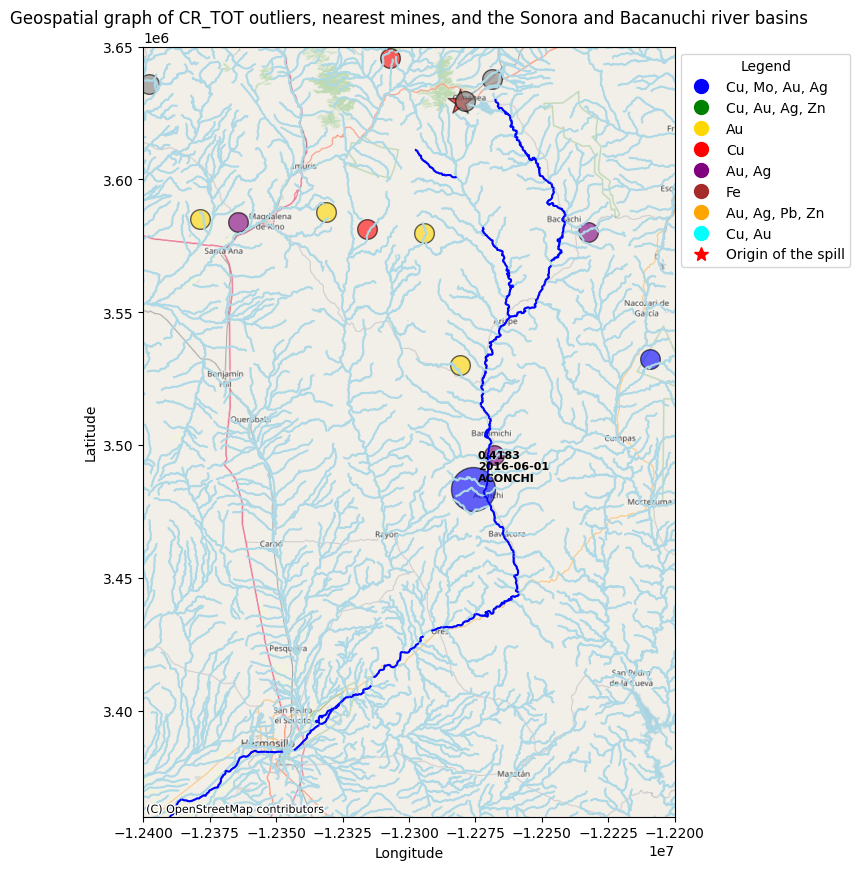

In [32]:
mining_river(df_outliers, "CR_TOT", df_mining_2013)

In [33]:
df_drop_water_sonora_copy = df_drop_water_sonora.copy(deep=True)
df_drop_water_sonora_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CLAVE SITIO          473 non-null    object        
 1   ESTADO               473 non-null    object        
 2   MUNICIPIO            473 non-null    object        
 3   CUERPO DE AGUA       473 non-null    object        
 4   TIPO CUERPO DE AGUA  473 non-null    object        
 5   SUBTIPO CUERPO AGUA  473 non-null    object        
 6   LATITUD              473 non-null    float64       
 7   LONGITUD             473 non-null    float64       
 8   FECHA REALIZACIÓN    473 non-null    datetime64[ns]
 9   COLI_FEC             452 non-null    float64       
 10  E_COLI               349 non-null    float64       
 11  COT                  405 non-null    float64       
 12  DBO_TOT              349 non-null    float64       
 13  DQO_TOT              347 non-null  

In [34]:
filtered_df = df_drop_water_sonora_copy.loc[~df_drop_water_sonora_copy.index.isin(df_outliers.index)]
filtered_df[
    ['CLAVE SITIO', 'ESTADO', 'MUNICIPIO', 'CUERPO DE AGUA', 'TIPO CUERPO DE AGUA', 'SUBTIPO CUERPO AGUA', 'LATITUD', 'LONGITUD', 'FECHA REALIZACIÓN'] + 
    POLLUTANTS
]

,CLAVE SITIO,ESTADO,MUNICIPIO,CUERPO DE AGUA,TIPO CUERPO DE AGUA,SUBTIPO CUERPO AGUA,LATITUD,LONGITUD,FECHA REALIZACIÓN,OD_mg/L,...,E_COLI,N_TOT,P_TOT,TOX_D_48_UT,SST,AS_TOT,CD_TOT,CR_TOT,HG_TOT,PB_TOT
7,MET-011,SONORA,ARIZPE,ACUÍFERO RÍO SONORA,SUBTERRÁNEO,POZO,30.29556,-110.18945,2021-10-26,3.85,...,NaN,0.886575,0.0719,NaN,10.0,0.0015,0.001301,0.0012,0.000201,0.00154
8,MET-011A,SONORA,ARIZPE,RIO SONORA,LÓTICO,RÍO,30.29822,-110.18746,2022-07-26,5.75,...,14136.0,NaN,NaN,1.0,7583.3,0.0380,0.004000,0.0240,0.000201,0.17200
9,MET-012,SONORA,ARIZPE,ACUÍFERO RIO SONORA,SUBTERRÁNEO,POZO,30.29633,-110.18674,2022-07-26,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0015,0.001301,0.0012,0.000201,0.00154
10,MET-012,SONORA,ARIZPE,ACUÍFERO RIO SONORA,SUBTERRÁNEO,POZO,30.29633,-110.18674,2023-12-04,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0020,0.001000,0.0020,0.000100,0.00200
11,MET-013,SONORA,ARIZPE,ACUÍFERO RÍO SONORA,SUBTERRÁNEO,POZO,30.15875,-110.24447,2021-09-08,7.44,...,NaN,2.308714,0.0262,NaN,10.0,0.0015,0.001301,0.0012,0.000201,0.00154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,OCNOR6275,SONORA,CANANEA,ACUÍFERO SAN PEDRO,SUBTERRÁNEO,POZO,31.08505,-110.11187,2022-08-15,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0015,0.001301,0.0060,0.000201,0.00154
469,OCNOR6506,SONORA,URES,ACUÍFERO RÍO SONORA,SUBTERRÁNEO,POZO,29.42405,-110.38294,2020-10-31,NaN,...,NaN,5.652401,0.0175,NaN,NaN,0.0015,0.001301,0.0056,0.000201,0.00154
470,TOMA DOMICILIARIA ACONCHI,SONORA,ACONCHI,ACUÍFERO RIO SONORA,SUBTERRÁNEO,TOMA DOMICILIARIA,29.82151,-110.22702,2022-08-11,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0080,0.001301,0.0012,0.000201,0.00154
471,TOMA DOMICILIARIA BACANUCHI ESCUELA,SONORA,ARIZPE,ACUÍFERO RIO BACANUCHI,SUBTERRÁNEO,TOMA DOMICILIARIA,30.60567,-110.23583,2022-07-25,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0015,0.001301,0.0012,0.000201,0.00154


In [35]:
WATER_PROCESSED_DATA_DIR = PROCESSED_DATA_DIR / 'water_quality_tidy_data_filtered.parquet' 
filtered_df = df_drop_water_sonora_copy.loc[~df_drop_water_sonora_copy.index.isin([43, 44, 62, 98])]
filtered_df = filtered_df[
    ['CLAVE SITIO', 'ESTADO', 'MUNICIPIO', 'CUERPO DE AGUA', 'TIPO CUERPO DE AGUA', 'SUBTIPO CUERPO AGUA', 'LATITUD', 'LONGITUD', 'FECHA REALIZACIÓN'] + 
    POLLUTANTS
]
write_parquet(filtered_df, WATER_PROCESSED_DATA_DIR, 10)

2024-11-18 18:31:01.545 | INFO     | modules.dataset_modules.uploader:write_parquet:22 - Starting to write Parquet file to /mnt/Data/Documents/Unison/1 Semestre/Ingeniería de Características/Projects/Sonora-River-Farming/Data-Science-Project/data/processed/water_quality_tidy_data_filtered.parquet with 469 rows.


Writing Parquet:   2%|▏         | 10/469 [00:00<00:00, 536.59rows/s]

Writing Parquet:   6%|▋         | 30/469 [00:00<00:00, 606.80rows/s]

2024-11-18 18:31:01.578 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 0 to 10 to Parquet.
2024-11-18 18:31:01.588 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 10 to 20 to Parquet.
2024-11-18 18:31:01.611 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 20 to 30 to Parquet.


Writing Parquet:  28%|██▊       | 130/469 [00:00<00:00, 595.87rows/s]

2024-11-18 18:31:01.623 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 30 to 40 to Parquet.
2024-11-18 18:31:01.637 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 40 to 50 to Parquet.
2024-11-18 18:31:01.657 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 50 to 60 to Parquet.
2024-11-18 18:31:01.688 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 60 to 70 to Parquet.
2024-11-18 18:31:01.697 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 70 to 80 to Parquet.
2024-11-18 18:31:01.705 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 80 to 90 to Parquet.
2024-11-18 18:31:01.711 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 90 to 100 to Parquet.
2024-11-18 18:31:01.719 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 100 to 110 to Parquet.
2024-11-18 18

Writing Parquet:  38%|███▊      | 180/469 [00:00<00:00, 595.87rows/s]

2024-11-18 18:31:01.747 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 130 to 140 to Parquet.
2024-11-18 18:31:01.756 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 140 to 150 to Parquet.
2024-11-18 18:31:01.764 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 150 to 160 to Parquet.
2024-11-18 18:31:01.773 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 160 to 170 to Parquet.
2024-11-18 18:31:01.779 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 170 to 180 to Parquet.


Writing Parquet:  47%|████▋     | 220/469 [00:00<00:00, 907.74rows/s]

2024-11-18 18:31:01.788 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 180 to 190 to Parquet.
2024-11-18 18:31:01.801 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 190 to 200 to Parquet.
2024-11-18 18:31:01.813 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 200 to 210 to Parquet.
2024-11-18 18:31:01.825 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 210 to 220 to Parquet.


Writing Parquet:  64%|██████▍   | 300/469 [00:00<00:00, 796.39rows/s]

2024-11-18 18:31:01.833 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 220 to 230 to Parquet.
2024-11-18 18:31:01.844 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 230 to 240 to Parquet.
2024-11-18 18:31:01.859 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 240 to 250 to Parquet.
2024-11-18 18:31:01.885 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 250 to 260 to Parquet.
2024-11-18 18:31:01.903 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 260 to 270 to Parquet.
2024-11-18 18:31:01.918 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 270 to 280 to Parquet.
2024-11-18 18:31:01.934 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 280 to 290 to Parquet.
2024-11-18 18:31:01.945 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 290 to 300 to Parquet.


Writing Parquet:  72%|███████▏  | 340/469 [00:00<00:00, 796.39rows/s]

2024-11-18 18:31:01.954 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 300 to 310 to Parquet.
2024-11-18 18:31:01.972 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 310 to 320 to Parquet.
2024-11-18 18:31:01.978 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 320 to 330 to Parquet.
2024-11-18 18:31:01.989 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 330 to 340 to Parquet.


Writing Parquet:  81%|████████  | 380/469 [00:00<00:00, 808.01rows/s]

2024-11-18 18:31:02.008 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 340 to 350 to Parquet.
2024-11-18 18:31:02.020 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 350 to 360 to Parquet.
2024-11-18 18:31:02.030 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 360 to 370 to Parquet.


Writing Parquet: 100%|██████████| 469/469 [00:00<00:00, 843.23rows/s]

2024-11-18 18:31:02.041 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 370 to 380 to Parquet.
2024-11-18 18:31:02.051 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 380 to 390 to Parquet.
2024-11-18 18:31:02.059 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 390 to 400 to Parquet.
2024-11-18 18:31:02.068 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 400 to 410 to Parquet.
2024-11-18 18:31:02.076 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 410 to 420 to Parquet.
2024-11-18 18:31:02.084 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 420 to 430 to Parquet.
2024-11-18 18:31:02.094 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 430 to 440 to Parquet.
2024-11-18 18:31:02.104 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 440 to 450 to Parquet.


In [4]:
FILE_NAME = 'water_quality_raw_data.xlsb'
WATER_RAW_DATA_DIR = RAW_DATA_DIR / FILE_NAME
DATA_DIR = PROCESSED_DATA_DIR / 'water_quality_tidy_data_results.parquet' 
df_water_result_sheet2 = df_water_result
df_water_result_sheet2['FECHA REALIZACIÓN'] = pd.to_numeric(df_water_result_sheet2['FECHA REALIZACIÓN'], errors='coerce')

min_valid_ns = 0
max_valid_ns = 2**63 - 1

# Filtrar valores dentro de este rango
valid_range = (df_water_result_sheet2['FECHA REALIZACIÓN'] >= min_valid_ns) & \
              (df_water_result_sheet2['FECHA REALIZACIÓN'] <= max_valid_ns)

df_water_result_sheet2 = df_water_result_sheet2[valid_range]

# Then convert to dates from Excel origin
df_water_result_sheet2['FECHA REALIZACIÓN'] = pd.to_datetime(
    df_water_result_sheet2['FECHA REALIZACIÓN'], 
    origin='1899-12-30', 
    unit='D'
)

serie_col = df_water_result_sheet2.columns

serie_col_poll = serie_col[~serie_col.isin(['CLAVE SITIO', 'CLAVE MONITOREO', 'NOMBRE DEL SITIO',
       'TIPO CUERPO DE AGUA', 'FECHA REALIZACIÓN', 'Año'])]
serie_col_poll

for column in serie_col_poll:
    if column in df_water_result_sheet2.columns:
        df_water_result_sheet2[column] = df_water_result_sheet2[column].astype(str)
        df_water_result_sheet2[column] = (
            df_water_result_sheet2[column]
            .str.replace('<', '', regex=False)
            .str.replace('>', '', regex=False)
        )
        df_water_result_sheet2[column] = pd.to_numeric(df_water_result_sheet2[column], errors='coerce')

print(df_water_result_sheet2['FECHA REALIZACIÓN'].max())
print(df_water_result_sheet2['FECHA REALIZACIÓN'].min())
df_water_result_sheet2['FECHA REALIZACIÓN'].describe()
write_parquet(df_water_result_sheet2, DATA_DIR, 1000)

/tmp/ipykernel_218636/2942903943.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_water_result_sheet2['FECHA REALIZACIÓN'] = pd.to_datetime(
/tmp/ipykernel_218636/2942903943.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_water_result_sheet2[column] = df_water_result_sheet2[column].astype(str)
/tmp/ipykernel_218636/2942903943.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

2023-12-12 00:00:00
2012-03-12 00:00:00
2024-11-18 19:10:19.680 | INFO     | modules.dataset_modules.uploader:write_parquet:22 - Starting to write Parquet file to /mnt/Data/Documents/Unison/1 Semestre/Ingeniería de Características/Projects/Sonora-River-Farming/Data-Science-Project/data/processed/water_quality_tidy_data_results.parquet with 127420 rows.


Writing Parquet:   2%|▏         | 3000/127420 [00:00<00:05, 23055.08rows/s]

2024-11-18 19:10:19.765 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 0 to 1000 to Parquet.
2024-11-18 19:10:19.810 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 1000 to 2000 to Parquet.
2024-11-18 19:10:19.848 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 2000 to 3000 to Parquet.


Writing Parquet:   4%|▍         | 5000/127420 [00:00<00:05, 23055.08rows/s]

2024-11-18 19:10:19.892 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 3000 to 4000 to Parquet.
2024-11-18 19:10:19.940 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 4000 to 5000 to Parquet.


Writing Parquet:   5%|▌         | 7000/127420 [00:00<00:05, 21878.35rows/s]

2024-11-18 19:10:19.990 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 5000 to 6000 to Parquet.
2024-11-18 19:10:20.051 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 6000 to 7000 to Parquet.


Writing Parquet:   8%|▊         | 10000/127420 [00:00<00:05, 20946.68rows/s]

2024-11-18 19:10:20.095 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 7000 to 8000 to Parquet.
2024-11-18 19:10:20.141 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 8000 to 9000 to Parquet.
2024-11-18 19:10:20.187 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 9000 to 10000 to Parquet.


Writing Parquet:   9%|▉         | 12000/127420 [00:00<00:05, 21064.52rows/s]

2024-11-18 19:10:20.233 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 10000 to 11000 to Parquet.
2024-11-18 19:10:20.282 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 11000 to 12000 to Parquet.


Writing Parquet:  11%|█         | 14000/127420 [00:00<00:05, 21064.52rows/s]

2024-11-18 19:10:20.337 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 12000 to 13000 to Parquet.
2024-11-18 19:10:20.391 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 13000 to 14000 to Parquet.


Writing Parquet:  13%|█▎        | 17000/127420 [00:00<00:05, 20208.52rows/s]

2024-11-18 19:10:20.440 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 14000 to 15000 to Parquet.
2024-11-18 19:10:20.487 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 15000 to 16000 to Parquet.
2024-11-18 19:10:20.538 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 16000 to 17000 to Parquet.


Writing Parquet:  14%|█▍        | 18000/127420 [00:00<00:05, 20387.26rows/s]

2024-11-18 19:10:20.587 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 17000 to 18000 to Parquet.


Writing Parquet:  15%|█▍        | 19000/127420 [00:00<00:05, 20387.26rows/s]

2024-11-18 19:10:20.683 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 18000 to 19000 to Parquet.


Writing Parquet:  16%|█▌        | 20000/127420 [00:01<00:05, 20387.26rows/s]

2024-11-18 19:10:20.817 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 19000 to 20000 to Parquet.


Writing Parquet:  17%|█▋        | 22000/127420 [00:01<00:07, 13892.14rows/s]

2024-11-18 19:10:20.944 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 20000 to 21000 to Parquet.
2024-11-18 19:10:21.007 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 21000 to 22000 to Parquet.


Writing Parquet:  18%|█▊        | 23000/127420 [00:01<00:07, 13287.16rows/s]

2024-11-18 19:10:21.115 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 22000 to 23000 to Parquet.


Writing Parquet:  20%|█▉        | 25000/127420 [00:01<00:07, 13896.77rows/s]

2024-11-18 19:10:21.171 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 23000 to 24000 to Parquet.
2024-11-18 19:10:21.241 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 24000 to 25000 to Parquet.


Writing Parquet:  20%|██        | 26000/127420 [00:01<00:07, 13896.77rows/s]

2024-11-18 19:10:21.333 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 25000 to 26000 to Parquet.


Writing Parquet:  21%|██        | 27000/127420 [00:01<00:07, 12701.76rows/s]

2024-11-18 19:10:21.438 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 26000 to 27000 to Parquet.


Writing Parquet:  23%|██▎       | 29000/127420 [00:01<00:08, 11677.87rows/s]

2024-11-18 19:10:21.578 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 27000 to 28000 to Parquet.


Writing Parquet:  24%|██▎       | 30000/127420 [00:02<00:08, 11677.87rows/s]

2024-11-18 19:10:21.642 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 28000 to 29000 to Parquet.
2024-11-18 19:10:21.766 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 29000 to 30000 to Parquet.


Writing Parquet:  24%|██▍       | 31000/127420 [00:02<00:08, 11573.23rows/s]

2024-11-18 19:10:21.818 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 30000 to 31000 to Parquet.


Writing Parquet:  27%|██▋       | 34000/127420 [00:02<00:07, 12516.85rows/s]

2024-11-18 19:10:21.886 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 31000 to 32000 to Parquet.
2024-11-18 19:10:21.946 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 32000 to 33000 to Parquet.
2024-11-18 19:10:22.004 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 33000 to 34000 to Parquet.


Writing Parquet:  27%|██▋       | 35000/127420 [00:02<00:06, 13549.17rows/s]

2024-11-18 19:10:22.064 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 34000 to 35000 to Parquet.


Writing Parquet:  30%|██▉       | 38000/127420 [00:02<00:06, 14313.83rows/s]

2024-11-18 19:10:22.119 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 35000 to 36000 to Parquet.
2024-11-18 19:10:22.185 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 36000 to 37000 to Parquet.
2024-11-18 19:10:22.244 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 37000 to 38000 to Parquet.


Writing Parquet:  31%|███       | 39000/127420 [00:02<00:05, 14853.08rows/s]

2024-11-18 19:10:22.313 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 38000 to 39000 to Parquet.


Writing Parquet:  31%|███▏      | 40000/127420 [00:02<00:05, 14853.08rows/s]

2024-11-18 19:10:22.417 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 39000 to 40000 to Parquet.


Writing Parquet:  32%|███▏      | 41000/127420 [00:02<00:07, 11392.90rows/s]

2024-11-18 19:10:22.588 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 40000 to 41000 to Parquet.


Writing Parquet:  33%|███▎      | 42000/127420 [00:03<00:07, 11392.90rows/s]

2024-11-18 19:10:22.724 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 41000 to 42000 to Parquet.


Writing Parquet:  35%|███▍      | 44000/127420 [00:03<00:08, 10281.59rows/s]

2024-11-18 19:10:22.820 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 42000 to 43000 to Parquet.
2024-11-18 19:10:22.885 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 43000 to 44000 to Parquet.


Writing Parquet:  36%|███▌      | 46000/127420 [00:03<00:07, 11534.87rows/s]

2024-11-18 19:10:22.943 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 44000 to 45000 to Parquet.
2024-11-18 19:10:22.995 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 45000 to 46000 to Parquet.


Writing Parquet:  38%|███▊      | 48000/127420 [00:03<00:06, 13046.83rows/s]

2024-11-18 19:10:23.049 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 46000 to 47000 to Parquet.
2024-11-18 19:10:23.115 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 47000 to 48000 to Parquet.


2024-11-18 19:10:23.160 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 48000 to 49000 to Parquet.
2024-11-18 19:10:23.207 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 49000 to 50000 to Parquet.


Writing Parquet:  42%|████▏     | 53000/127420 [00:03<00:04, 16198.60rows/s]

2024-11-18 19:10:23.251 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 50000 to 51000 to Parquet.
2024-11-18 19:10:23.305 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 51000 to 52000 to Parquet.
2024-11-18 19:10:23.348 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 52000 to 53000 to Parquet.


Writing Parquet:  42%|████▏     | 54000/127420 [00:03<00:04, 16198.60rows/s]

2024-11-18 19:10:23.393 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 53000 to 54000 to Parquet.


Writing Parquet:  45%|████▍     | 57000/127420 [00:03<00:03, 17880.89rows/s]

2024-11-18 19:10:23.456 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 54000 to 55000 to Parquet.
2024-11-18 19:10:23.509 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 55000 to 56000 to Parquet.
2024-11-18 19:10:23.557 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 56000 to 57000 to Parquet.


Writing Parquet:  46%|████▋     | 59000/127420 [00:03<00:03, 17880.89rows/s]

2024-11-18 19:10:23.596 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 57000 to 58000 to Parquet.
2024-11-18 19:10:23.641 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 58000 to 59000 to Parquet.


Writing Parquet:  48%|████▊     | 61000/127420 [00:04<00:03, 19052.33rows/s]

2024-11-18 19:10:23.698 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 59000 to 60000 to Parquet.
2024-11-18 19:10:23.755 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 60000 to 61000 to Parquet.


Writing Parquet:  49%|████▉     | 63000/127420 [00:04<00:03, 18529.27rows/s]

2024-11-18 19:10:23.812 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 61000 to 62000 to Parquet.
2024-11-18 19:10:23.870 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 62000 to 63000 to Parquet.


Writing Parquet:  51%|█████     | 65000/127420 [00:04<00:03, 18588.45rows/s]

2024-11-18 19:10:23.919 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 63000 to 64000 to Parquet.
2024-11-18 19:10:23.988 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 64000 to 65000 to Parquet.


Writing Parquet:  52%|█████▏    | 66000/127420 [00:04<00:03, 16315.86rows/s]

2024-11-18 19:10:24.082 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 65000 to 66000 to Parquet.


Writing Parquet:  53%|█████▎    | 68000/127420 [00:04<00:04, 14687.28rows/s]

2024-11-18 19:10:24.157 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 66000 to 67000 to Parquet.
2024-11-18 19:10:24.254 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 67000 to 68000 to Parquet.


Writing Parquet:  54%|█████▍    | 69000/127420 [00:04<00:03, 14687.28rows/s]

2024-11-18 19:10:24.337 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 68000 to 69000 to Parquet.


Writing Parquet:  57%|█████▋    | 72000/127420 [00:04<00:03, 15099.24rows/s]

2024-11-18 19:10:24.402 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 69000 to 70000 to Parquet.
2024-11-18 19:10:24.465 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 70000 to 71000 to Parquet.
2024-11-18 19:10:24.516 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 71000 to 72000 to Parquet.


Writing Parquet:  57%|█████▋    | 73000/127420 [00:04<00:03, 15099.24rows/s]

2024-11-18 19:10:24.561 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 72000 to 73000 to Parquet.


Writing Parquet:  60%|█████▉    | 76000/127420 [00:05<00:03, 15465.40rows/s]

2024-11-18 19:10:24.625 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 73000 to 74000 to Parquet.
2024-11-18 19:10:24.693 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 74000 to 75000 to Parquet.


Writing Parquet:  60%|██████    | 77000/127420 [00:05<00:03, 15465.40rows/s]

2024-11-18 19:10:24.763 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 75000 to 76000 to Parquet.
2024-11-18 19:10:24.819 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 76000 to 77000 to Parquet.


Writing Parquet:  61%|██████    | 78000/127420 [00:05<00:03, 16234.08rows/s]

2024-11-18 19:10:24.872 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 77000 to 78000 to Parquet.


Writing Parquet:  63%|██████▎   | 80000/127420 [00:05<00:03, 13860.88rows/s]

2024-11-18 19:10:24.967 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 78000 to 79000 to Parquet.
2024-11-18 19:10:25.067 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 79000 to 80000 to Parquet.


Writing Parquet:  66%|██████▌   | 84000/127420 [00:05<00:03, 12596.82rows/s]

2024-11-18 19:10:25.179 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 80000 to 81000 to Parquet.
2024-11-18 19:10:25.259 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 81000 to 82000 to Parquet.
2024-11-18 19:10:25.313 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 82000 to 83000 to Parquet.
2024-11-18 19:10:25.356 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 83000 to 84000 to Parquet.


Writing Parquet:  70%|██████▉   | 89000/127420 [00:05<00:02, 15933.04rows/s]

2024-11-18 19:10:25.398 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 84000 to 85000 to Parquet.
2024-11-18 19:10:25.449 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 85000 to 86000 to Parquet.
2024-11-18 19:10:25.503 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 86000 to 87000 to Parquet.
2024-11-18 19:10:25.541 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 87000 to 88000 to Parquet.
2024-11-18 19:10:25.585 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 88000 to 89000 to Parquet.


Writing Parquet:  73%|███████▎  | 93000/127420 [00:06<00:01, 18367.88rows/s]

2024-11-18 19:10:25.631 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 89000 to 90000 to Parquet.
2024-11-18 19:10:25.680 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 90000 to 91000 to Parquet.
2024-11-18 19:10:25.737 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 91000 to 92000 to Parquet.
2024-11-18 19:10:25.806 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 92000 to 93000 to Parquet.


Writing Parquet:  76%|███████▌  | 97000/127420 [00:06<00:01, 17381.64rows/s]

2024-11-18 19:10:25.864 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 93000 to 94000 to Parquet.
2024-11-18 19:10:25.924 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 94000 to 95000 to Parquet.
2024-11-18 19:10:25.980 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 95000 to 96000 to Parquet.
2024-11-18 19:10:26.028 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 96000 to 97000 to Parquet.


Writing Parquet:  80%|████████  | 102000/127420 [00:06<00:01, 19878.64rows/s]

2024-11-18 19:10:26.072 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 97000 to 98000 to Parquet.
2024-11-18 19:10:26.123 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 98000 to 99000 to Parquet.
2024-11-18 19:10:26.170 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 99000 to 100000 to Parquet.
2024-11-18 19:10:26.215 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 100000 to 101000 to Parquet.
2024-11-18 19:10:26.254 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 101000 to 102000 to Parquet.


Writing Parquet:  84%|████████▍ | 107000/127420 [00:06<00:01, 20234.01rows/s]

2024-11-18 19:10:26.296 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 102000 to 103000 to Parquet.
2024-11-18 19:10:26.345 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 103000 to 104000 to Parquet.
2024-11-18 19:10:26.397 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 104000 to 105000 to Parquet.
2024-11-18 19:10:26.446 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 105000 to 106000 to Parquet.
2024-11-18 19:10:26.490 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 106000 to 107000 to Parquet.


Writing Parquet:  88%|████████▊ | 112000/127420 [00:07<00:00, 20703.62rows/s]

2024-11-18 19:10:26.538 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 107000 to 108000 to Parquet.
2024-11-18 19:10:26.585 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 108000 to 109000 to Parquet.
2024-11-18 19:10:26.635 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 109000 to 110000 to Parquet.
2024-11-18 19:10:26.681 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 110000 to 111000 to Parquet.
2024-11-18 19:10:26.727 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 111000 to 112000 to Parquet.


Writing Parquet:  91%|█████████ | 116000/127420 [00:07<00:00, 19720.70rows/s]

2024-11-18 19:10:26.774 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 112000 to 113000 to Parquet.
2024-11-18 19:10:26.851 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 113000 to 114000 to Parquet.
2024-11-18 19:10:26.907 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 114000 to 115000 to Parquet.
2024-11-18 19:10:26.950 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 115000 to 116000 to Parquet.


Writing Parquet:  93%|█████████▎| 118000/127420 [00:07<00:00, 18286.68rows/s]

2024-11-18 19:10:26.995 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 116000 to 117000 to Parquet.
2024-11-18 19:10:27.085 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 117000 to 118000 to Parquet.


Writing Parquet:  95%|█████████▍| 121000/127420 [00:07<00:00, 14575.51rows/s]

2024-11-18 19:10:27.203 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 118000 to 119000 to Parquet.
2024-11-18 19:10:27.304 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 119000 to 120000 to Parquet.
2024-11-18 19:10:27.379 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 120000 to 121000 to Parquet.


Writing Parquet:  99%|█████████▉| 126000/127420 [00:07<00:00, 16017.65rows/s]

2024-11-18 19:10:27.419 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 121000 to 122000 to Parquet.
2024-11-18 19:10:27.476 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 122000 to 123000 to Parquet.
2024-11-18 19:10:27.527 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 123000 to 124000 to Parquet.
2024-11-18 19:10:27.566 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 124000 to 125000 to Parquet.
2024-11-18 19:10:27.605 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 125000 to 126000 to Parquet.


Writing Parquet: 100%|██████████| 127420/127420 [00:07<00:00, 15960.74rows/s]


2024-11-18 19:10:27.649 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 126000 to 127000 to Parquet.
2024-11-18 19:10:27.696 | DEBUG    | modules.dataset_modules.uploader:write_parquet:40 - Written rows 127000 to 127420 to Parquet.
2024-11-18 19:10:27.806 | SUCCESS  | modules.dataset_modules.uploader:write_parquet:42 - Parquet file successfully written to /mnt/Data/Documents/Unison/1 Semestre/Ingeniería de Características/Projects/Sonora-River-Farming/Data-Science-Project/data/processed/water_quality_tidy_data_results.parquet.
